In [125]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import datetime
from dateutil import parser
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

In [25]:
path = '/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_1_raw_data/testing/run1_check_adherence/'

In [193]:
save_path = '/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/'

In [15]:
# Study Participants

In [26]:
subjects = pd.read_csv(path + 'run1_participants.csv')
subjects = subjects.ParticipantIdentifier

## Survey Questions

In [197]:
# erase df if it already exists
if 'df' in globals():
    del(df)
    print('deleted existing df')

deleted existing df


In [198]:
# loop through all days
days = [i for i in os.listdir(path) if i.startswith('RK')]
for day in tqdm(days):
    files = os.listdir(path + day)
    surveyQuestions = [i for i in files if i.startswith('SurveyQuestionResults')]
    # there should be only one
    for file in surveyQuestions:
        if 'df' not in globals():
            df = pd.read_csv(path + day + '/' + file)
        else:
            temp_df = pd.read_csv(path + day + '/' + file)
            df = pd.concat([df,temp_df], axis=0)

100%|██████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 21.81it/s]


In [199]:
df.shape

(396579, 8)

In [200]:
# select relevant columns
df = df[['ParticipantIdentifier', 'ResultIdentifier', 'Answers', 'EndDate']]
df = df.reset_index(drop=True)
df.head()

,ParticipantIdentifier,ResultIdentifier,Answers,EndDate
0,6338356d-f098-46ea-b270-10c6fff7e67e,WEEKLY_goal_report1,19,2022-10-21T21:55:56-04:00
1,6338356d-f098-46ea-b270-10c6fff7e67e,WEEKLY_goal_report2,2,2022-10-21T21:55:59-04:00
2,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,task_custom_bart_info1,"{""totalEarnings"":0}",2022-10-24T07:04:41-04:00
3,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,task_custom_bart_info2,"{""totalEarnings"":0}",2022-10-24T07:04:41-04:00
4,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,task_custom_bart_info3,"{""totalEarnings"":0}",2022-10-24T07:04:42-04:00


In [201]:
# check for na dates...
df.isna().sum()

ParticipantIdentifier     0
ResultIdentifier          0
Answers                   0
EndDate                  15
dtype: int64

In [202]:
df = df.dropna(subset=['EndDate']).reset_index(drop=True)

In [203]:
# select only subjects in run 1
df = df.loc[df.ParticipantIdentifier.isin(subjects)].reset_index(drop=True)

In [204]:
# add trial date and time columns
for i in tqdm(range(df.shape[0])):
    dt = parser.parse(df.loc[i, 'EndDate'])
    df.loc[i, 'datetime'] = dt
    df.loc[i, 'trial_date'] = (dt + datetime.timedelta(hours = -4)).date() # trial day associated with sample (4am is when the day flips)
    df.loc[i, 'time'] = dt.time()

100%|████████████████████████████████████████████████████████| 390923/390923 [01:19<00:00, 4926.55it/s]


In [205]:
df.head()

,ParticipantIdentifier,ResultIdentifier,Answers,EndDate,datetime,trial_date,time
0,6338356d-f098-46ea-b270-10c6fff7e67e,WEEKLY_goal_report1,19,2022-10-21T21:55:56-04:00,2022-10-21 21:55:56-04:00,2022-10-21,21:55:56
1,6338356d-f098-46ea-b270-10c6fff7e67e,WEEKLY_goal_report2,2,2022-10-21T21:55:59-04:00,2022-10-21 21:55:59-04:00,2022-10-21,21:55:59
2,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,task_custom_bart_info1,"{""totalEarnings"":0}",2022-10-24T07:04:41-04:00,2022-10-24 07:04:41-04:00,2022-10-24,07:04:41
3,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,task_custom_bart_info2,"{""totalEarnings"":0}",2022-10-24T07:04:41-04:00,2022-10-24 07:04:41-04:00,2022-10-24,07:04:41
4,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,task_custom_bart_info3,"{""totalEarnings"":0}",2022-10-24T07:04:42-04:00,2022-10-24 07:04:42-04:00,2022-10-24,07:04:42


In [213]:
# save to csv
df.to_csv(save_path + 'run1_survey_results.csv')

# Gap App

## Self Report

### Affect

#### Select Data

In [102]:
df_affect = df.loc[df.ResultIdentifier.str.startswith('affect_')].reset_index(drop=True)
df_affect_am = df.loc[(df.ResultIdentifier.str.startswith('affect_')) & (df.ResultIdentifier.str.endswith('am'))].reset_index(drop=True)
df_affect_pm = df.loc[(df.ResultIdentifier.str.startswith('affect_')) & (~df.ResultIdentifier.str.endswith('am'))].reset_index(drop=True)

In [105]:
df_affect_am.shape

(22060, 7)

In [106]:
df_affect_pm.shape

(54840, 7)

#### Convert to Wide

In [832]:
df_affect_pm_wide = df_affect_pm.pivot_table(index=["ParticipantIdentifier", "trial_date"], 
                    columns='ResultIdentifier', 
                    values='Answers').reset_index()
# get rid of name on index
df_affect_pm_wide = df_affect_pm_wide.rename_axis(None, axis=1)

df_affect_am_wide = df_affect_am.pivot_table(index=["ParticipantIdentifier", "trial_date"], 
                    columns='ResultIdentifier', 
                    values='Answers').reset_index()
# get rid of name on index
df_affect_am_wide = df_affect_am_wide.rename_axis(None, axis=1)

In [833]:
# join
df_daily_affect_wide = df_affect_pm_wide.merge(df_affect_am_wide, how='left', on=['ParticipantIdentifier', 'trial_date'])

df_daily_affect_wide.head(3)

,ParticipantIdentifier,trial_date,affect_neg_angry,affect_neg_ashamed,affect_neg_bored,affect_neg_depressed,affect_neg_embarrassed,affect_neg_frustrated,affect_neg_guilty,affect_neg_lazy,...,affect_neg_sad_am,affect_neg_stressed_am,affect_pos_amused_am,affect_pos_appreciated_am,affect_pos_excited_am,affect_pos_focused_am,affect_pos_happy_am,affect_pos_hopeful_am,affect_pos_motivated_am,affect_pos_relaxedCalm_am
0,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-09-27,1.0,1.0,1.0,1.0,2.0,3.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-09-30,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2022-10-01,1.0,1.0,1.0,1.0,1.0,3.0,2.0,1.0,...,2.0,3.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


In [835]:
# save to csv
df_daily_affect_wide.to_csv(save_path + 'run1_affect.csv', index=False)

#### Correlations

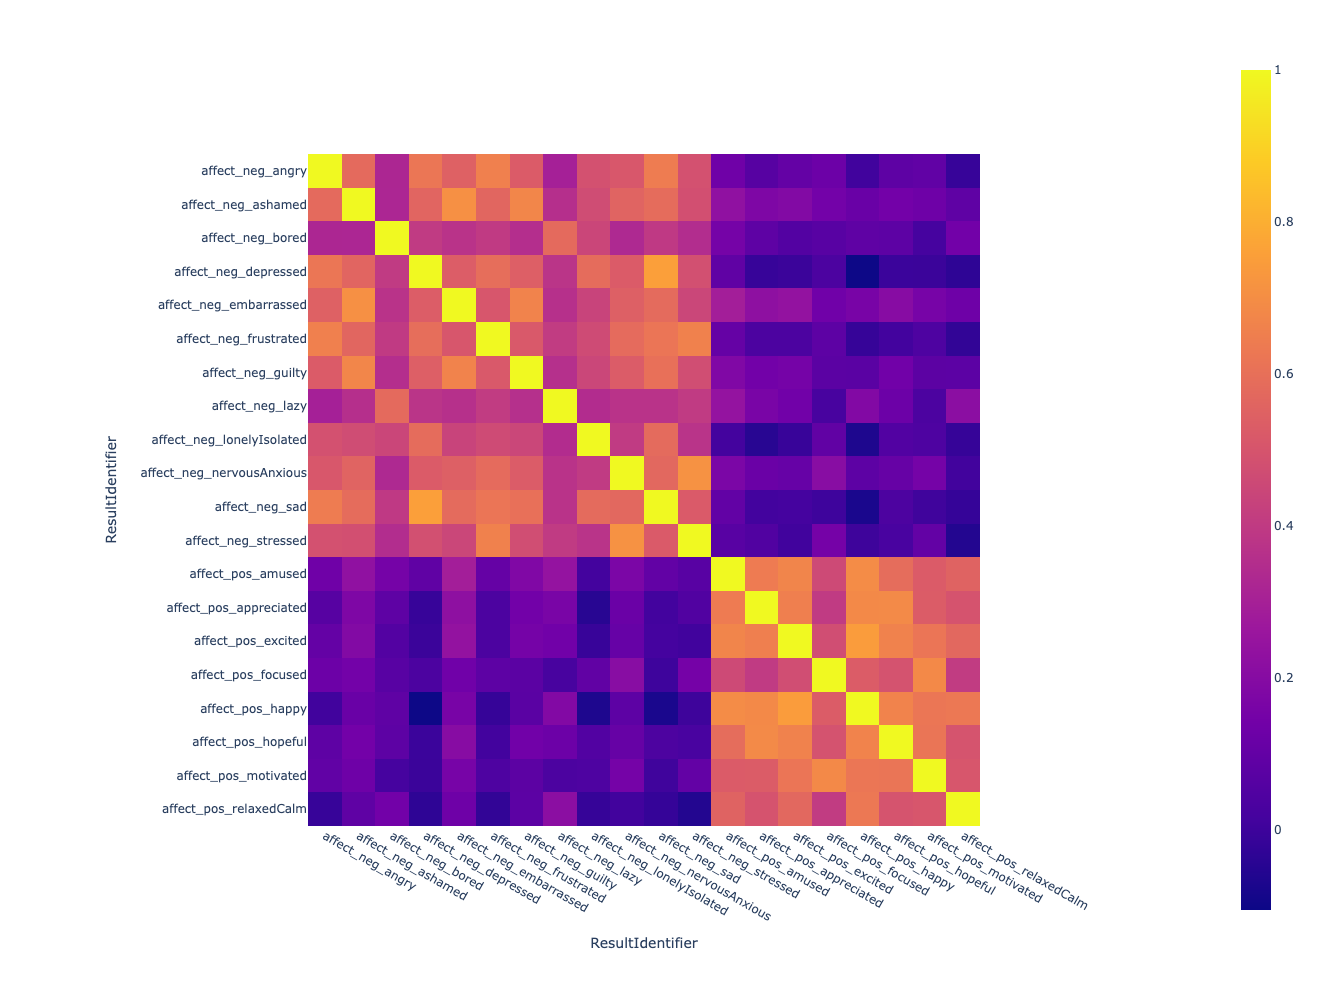

In [154]:
import plotly.express as px

dfp = df_affect_pm_wide.loc[:, 'affect_neg_angry':]

fig = px.imshow(dfp.corr())
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,)
fig.show()

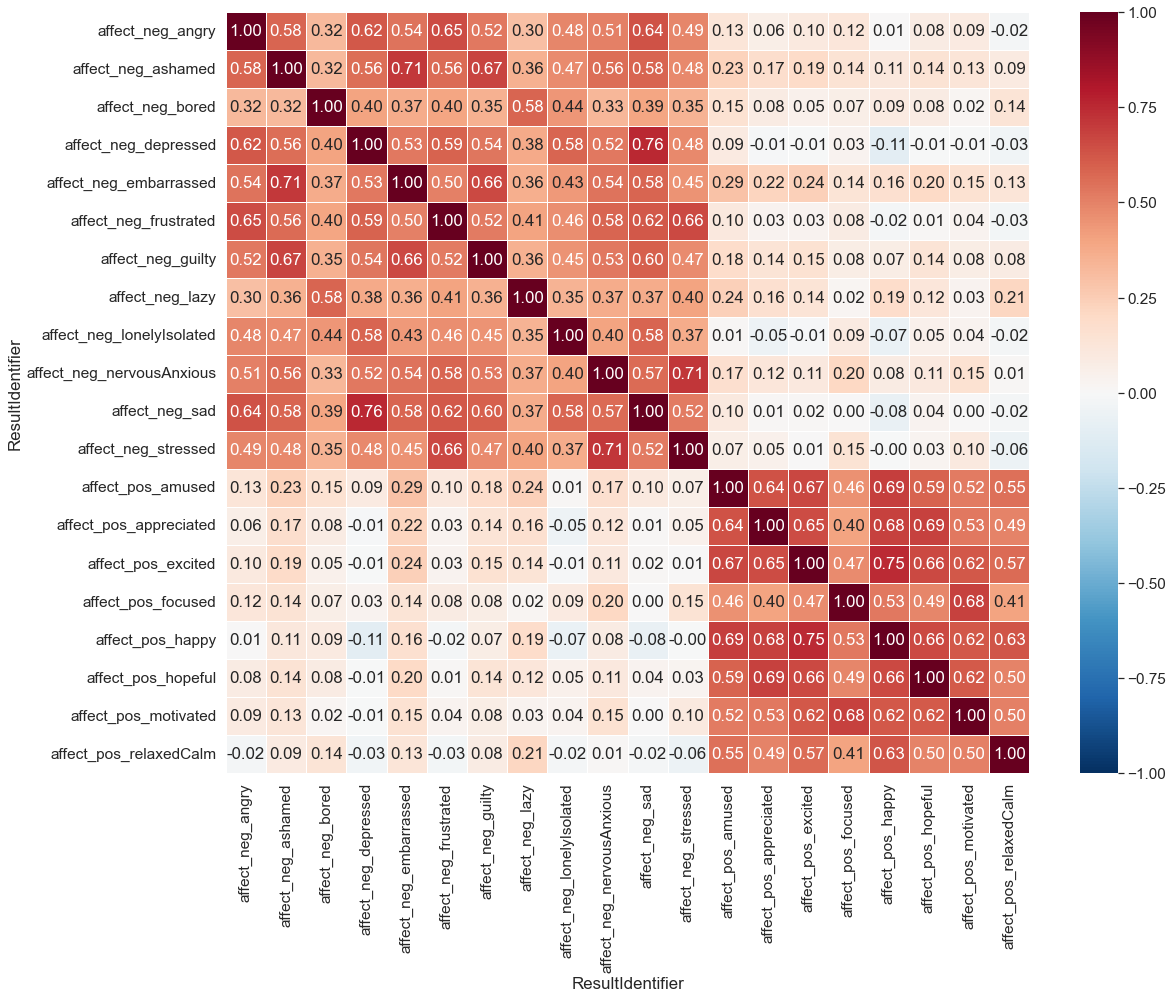

In [158]:
sns.set(rc={'figure.figsize':(18,14)})
sns.set(font_scale=1.4)

dfp = df_affect_pm_wide.loc[:, 'affect_neg_angry':]

sns.heatmap(dfp.corr(), 
            xticklabels=dfp.columns,
            yticklabels=dfp.columns,
            vmin = -1,
            vmax = 1,
            cmap='RdBu_r',
            annot=True,
            fmt='.2f',
            linewidth=0.5);

#### Autocor

In [164]:
df_affect_pm.Answers = pd.to_numeric(df_affect_pm.Answers)

In [179]:
counts = pd.DataFrame(df_affect_pm.groupby(['ParticipantIdentifier', 'ResultIdentifier'])['Answers'].count()).reset_index()

In [169]:
lag1_affect = pd.DataFrame(df_affect_pm.groupby(['ParticipantIdentifier', 'ResultIdentifier'])['Answers'].apply(pd.Series.autocorr, lag=1)).reset_index()
lag2_affect = pd.DataFrame(df_affect_pm.groupby(['ParticipantIdentifier', 'ResultIdentifier'])['Answers'].apply(pd.Series.autocorr, lag=2)).reset_index()
lag3_affect = pd.DataFrame(df_affect_pm.groupby(['ParticipantIdentifier', 'ResultIdentifier'])['Answers'].apply(pd.Series.autocorr, lag=3)).reset_index()

/Users/djw/opt/miniconda3/envs/battery/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/djw/opt/miniconda3/envs/battery/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning:

Degrees of freedom <= 0 for slice



In [180]:
lag1_affect['count'] = counts.Answers

0       35
1       35
2       35
3       35
4       35
        ..
1855    16
1856    16
1857    16
1858    16
1859    16
Name: Answers, Length: 1860, dtype: int64

In [189]:
lag1_affect

,ParticipantIdentifier,ResultIdentifier,Answers,count
0,01801252-3a7e-4f5f-8b6d-49e8da3902f3,affect_neg_angry,-0.259259,35
1,01801252-3a7e-4f5f-8b6d-49e8da3902f3,affect_neg_ashamed,0.409775,35
2,01801252-3a7e-4f5f-8b6d-49e8da3902f3,affect_neg_bored,-0.030303,35
3,01801252-3a7e-4f5f-8b6d-49e8da3902f3,affect_neg_depressed,NaN,35
4,01801252-3a7e-4f5f-8b6d-49e8da3902f3,affect_neg_embarrassed,-0.032484,35
...,...,...,...,...
1855,ff129772-aeab-4432-8136-8f94027b8504,affect_pos_focused,0.176829,16
1856,ff129772-aeab-4432-8136-8f94027b8504,affect_pos_happy,0.014634,16
1857,ff129772-aeab-4432-8136-8f94027b8504,affect_pos_hopeful,-0.220930,16
1858,ff129772-aeab-4432-8136-8f94027b8504,affect_pos_motivated,-0.141019,16


### Daily General and Detail

#### Select Data

In [280]:
past24_general = [
    'DAILY_survey_situation1_surveys',
    'DAILY_survey_situation2_surveys',
    'DAILY_survey_missed',
    'DAILY_past48to24_gap',
    'DAILY_past48to24_gapCause',
    'DAILY_past24_ideal',
    'DAILY_past24_satisfaction',
    'DAILY_past24_change',
    'DAILY_past24_productivity',
    'DAILY_past24_procrastination',
    'DAILY_past24_punctuality',
    'DAILY_past24_mentalEffort',
    'DAILY_past24_physicalEffort',
    'DAILY_past24_values',
    'DAILY_past24_gap',
    'DAILY_past24_gapCause',
    'DAILY_past24_illness',
    'DAILY_past24_fatigue',
    'DAILY_past24_unusualEvents   '
]

past24_categories = [
    'DAILY_past24_sleep',
    'DAILY_past24_occupation',
    'DAILY_past24_nonoccupation',
    'DAILY_past24_exercise',
    'DAILY_past24_leisureSolo',
    'DAILY_past24_leisureSoloMental',
    'DAILY_past24_leisureSoloPhysical',
    'DAILY_past24_leisureNonSolo',
    'DAILY_past24_leisureNonSoloMental',
    'DAILY_past24_leisureNonSoloPhysical',
    'DAILY_past24_diet',
    'DAILY_past24_socialMedia',
    'DAILY_past24_drinks'
]

next24_categories = [
    'DAILY_next24_sleep',
    'DAILY_next24_occupation',
    'DAILY_next24_nonoccupation',
    'DAILY_next24_leisureSolo',
    'DAILY_next24_leisureNonSolo',
    'DAILY_next24_exercise',
    'DAILY_next24_socialMedia',
    'DAILY_next24_drinks',
    'DAILY_next24_diet'
]

specific_goals = [
    'DAILY_goal1_report',
    'DAILY_goal1_importance',
    'DAILY_goal1_consequences',
    'DAILY_goal1_motivationInternal',
    'DAILY_goal1_motivationExternal',
    'DAILY_goal1_confidence',
    'DAILY_goal1_effort',
    'DAILY_goal1_interaction_week',
    'DAILY_goal1_interaction_month',
    'DAILY_goal2_report',
    'DAILY_goal2_importance',
    'DAILY_goal2_consequences',
    'DAILY_goal2_motivationInternal',
    'DAILY_goal2_motivationExternal',
    'DAILY_goal2_confidence',
    'DAILY_goal2_effort',
    'DAILY_goal2_interaction_week',
    'DAILY_goal2_interaction_month',
    'DAILY_goal2_interaction_eachOther'
]

non_numeric_cols = [
    'ParticipantIdentifier', 
    'trial_date',
    'DAILY_next24_diet',
    'DAILY_past48to24_gapCause',
    'DAILY_survey_situation1_surveys',
    'DAILY_survey_situation2_surveys',
    'DAILY_survey_missed',
    'DAILY_past24_gapCause'
]

In [251]:
df_daily_sr = df.loc[df.ResultIdentifier.isin(past24_general + 
                                              past24_categories + 
                                              next24_categories + 
                                              specific_goals)].reset_index(drop=True)

In [275]:
df_daily_sr.head(3)

,ParticipantIdentifier,ResultIdentifier,Answers,EndDate,datetime,trial_date,time
0,90592e06-bcf6-4150-85b0-c5daf7e7569c,DAILY_survey_situation1_surveys,alone,2022-10-24T19:59:12-04:00,2022-10-24 19:59:12-04:00,2022-10-24,19:59:12
1,90592e06-bcf6-4150-85b0-c5daf7e7569c,DAILY_survey_missed,did_not_miss,2022-10-24T19:59:13-04:00,2022-10-24 19:59:13-04:00,2022-10-24,19:59:13
2,90592e06-bcf6-4150-85b0-c5daf7e7569c,DAILY_past24_ideal,13,2022-10-24T19:59:17-04:00,2022-10-24 19:59:17-04:00,2022-10-24,19:59:17


#### Convert to Wide

In [257]:
df_daily_sr_wide = df_daily_sr.pivot_table(index=["ParticipantIdentifier", "trial_date"],
                                           columns='ResultIdentifier',
                                           values='Answers',
                                           aggfunc=lambda x: ' '.join(x)).reset_index()
# get rid of name on index
df_daily_sr_wide = df_daily_sr_wide.rename_axis(None, axis=1)

In [284]:
# convert data to numeric where appropriate
df_daily_sr_wide.loc[:,df_daily_sr_wide.columns[~df_daily_sr_wide.columns.isin(non_numeric_cols)]] = df_daily_sr_wide.loc[:,df_daily_sr_wide.columns[~df_daily_sr_wide.columns.isin(non_numeric_cols)]].apply(pd.to_numeric, errors='coerce')

In [286]:
df_daily_sr_wide.head(3)

,ParticipantIdentifier,trial_date,DAILY_goal1_confidence,DAILY_goal1_consequences,DAILY_goal1_effort,DAILY_goal1_importance,DAILY_goal1_interaction_month,DAILY_goal1_interaction_week,DAILY_goal1_motivationExternal,DAILY_goal1_motivationInternal,...,DAILY_past24_punctuality,DAILY_past24_satisfaction,DAILY_past24_sleep,DAILY_past24_socialMedia,DAILY_past24_values,DAILY_past48to24_gap,DAILY_past48to24_gapCause,DAILY_survey_missed,DAILY_survey_situation1_surveys,DAILY_survey_situation2_surveys
0,0501ba67-3406-4779-aff1-878a0e9f7885,2022-09-30,4.0,3.0,6.0,5.0,NaN,NaN,7.0,6.0,...,100.0,30.0,7.5,20.0,NaN,NaN,NaN,did_not_miss,with_friend,False
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-01,5.0,4.0,7.0,7.0,NaN,NaN,6.0,7.0,...,81.0,33.0,6.0,10.0,NaN,60.0,80_20,missed_busy,alone,NaN
2,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-02,7.0,5.0,4.0,7.0,NaN,NaN,7.0,5.0,...,80.0,70.0,9.0,5.0,NaN,NaN,NaN,did_not_miss,with_friend,False


#### Category Gap Calculation

<div class="alert alert-block alert-info">
<b>📝 Note:</b><br>
    I am assuming that peoples' goals are directional in a way that MAY NOT BE ACCURATE for everyone.<br><br>
    For example, I am assuming that people want to sleep more and drink less - in other words they have a <b>gap</b> if they have <b>more</b> drinks than planned, but for **sleep** the gap calculation is reversed since we assume a gap means that you had <b>fewer</b> hours of sleep than planned.<br><br>
    While this may be accurate <i>in general</i> I would reasonably expect there to be exceptions.
</div>

In [292]:
# calculate diet gap
df_daily_sr_wide.DAILY_past24_diet = 100 - df_daily_sr_wide.DAILY_past24_diet

In [297]:
# take the prediction from the day before and subtract it from the actual...
for i in range(df_daily_sr_wide.shape[0]-1):
    df_daily_sr_wide.loc[i+1, 'DAILY_gap_sleep'] =  df_daily_sr_wide.loc[i, 'DAILY_next24_sleep'] - df_daily_sr_wide.loc[i+1, 'DAILY_past24_sleep']
    df_daily_sr_wide.loc[i+1, 'DAILY_gap_occupation'] =  df_daily_sr_wide.loc[i, 'DAILY_next24_occupation'] - df_daily_sr_wide.loc[i+1, 'DAILY_past24_occupation']    
    df_daily_sr_wide.loc[i+1, 'DAILY_gap_nonoccupation'] =  df_daily_sr_wide.loc[i, 'DAILY_next24_nonoccupation'] - df_daily_sr_wide.loc[i+1, 'DAILY_past24_nonoccupation']    
    df_daily_sr_wide.loc[i+1, 'DAILY_gap_leisureSolo'] =  df_daily_sr_wide.loc[i+1, 'DAILY_past24_leisureSolo'] - df_daily_sr_wide.loc[i, 'DAILY_next24_leisureSolo'] # reversed
    df_daily_sr_wide.loc[i+1, 'DAILY_gap_leisureNonSolo'] =  df_daily_sr_wide.loc[i+1, 'DAILY_past24_leisureNonSolo']  - df_daily_sr_wide.loc[i, 'DAILY_next24_leisureNonSolo'] # reversed
    df_daily_sr_wide.loc[i+1, 'DAILY_gap_exercise'] =  df_daily_sr_wide.loc[i, 'DAILY_next24_exercise'] - df_daily_sr_wide.loc[i+1, 'DAILY_past24_exercise']    
    df_daily_sr_wide.loc[i+1, 'DAILY_gap_socialMedia'] =  df_daily_sr_wide.loc[i+1, 'DAILY_past24_socialMedia'] - df_daily_sr_wide.loc[i, 'DAILY_next24_socialMedia'] # reversed 
    df_daily_sr_wide.loc[i+1, 'DAILY_gap_drinks'] =  df_daily_sr_wide.loc[i+1, 'DAILY_past24_drinks'] - df_daily_sr_wide.loc[i, 'DAILY_next24_drinks'] # reversed
    

In [506]:
df_daily_sr_wide.columns

Index(['ParticipantIdentifier', 'trial_date', 'DAILY_goal1_confidence',
       'DAILY_goal1_consequences', 'DAILY_goal1_effort',
       'DAILY_goal1_importance', 'DAILY_goal1_interaction_month',
       'DAILY_goal1_interaction_week', 'DAILY_goal1_motivationExternal',
       'DAILY_goal1_motivationInternal', 'DAILY_goal1_report',
       'DAILY_goal2_confidence', 'DAILY_goal2_consequences',
       'DAILY_goal2_effort', 'DAILY_goal2_importance',
       'DAILY_goal2_interaction_eachOther', 'DAILY_goal2_interaction_month',
       'DAILY_goal2_interaction_week', 'DAILY_goal2_motivationExternal',
       'DAILY_goal2_motivationInternal', 'DAILY_goal2_report',
       'DAILY_next24_drinks', 'DAILY_next24_exercise',
       'DAILY_next24_leisureNonSolo', 'DAILY_next24_leisureSolo',
       'DAILY_next24_nonoccupation', 'DAILY_next24_occupation',
       'DAILY_next24_sleep', 'DAILY_next24_socialMedia', 'DAILY_past24_change',
       'DAILY_past24_diet', 'DAILY_past24_drinks', 'DAILY_past24_exercise',

In [837]:
# save to csv
df_daily_sr_wide.to_csv(save_path + 'run1_selfReport.csv', index=False)

## Custom Tasks


### N-Back

In [337]:
import json

In [351]:
nback_df = df.loc[df.ResultIdentifier == 'task_custom_nBack_results'].reset_index(drop=True)

In [352]:
for i in range(nback_df.shape[0]):
    nback_df.loc[i, 'task_nback_bid'] = json.loads(nback_df.Answers[i])['bid']
    nback_df.loc[i, 'task_nback_rndNum'] = json.loads(nback_df.Answers[i])['randomNumber']    
    nback_df.loc[i, 'task_nback_mode'] = json.loads(nback_df.Answers[i])['mode']
    nback_df.loc[i, 'task_nback_matched'] = json.loads(nback_df.Answers[i])['matched']    
    nback_df.loc[i, 'task_nback_falseAlarm'] = json.loads(nback_df.Answers[i])['falseAlarm']

In [353]:
nback_df = nback_df.drop(['ResultIdentifier', 'Answers', 'EndDate', 'datetime'], axis=1)
nback_df = nback_df.rename(columns={"time": "task_nback_time"})

### GoNoGo

In [425]:
gng_df =  df.loc[df.ResultIdentifier == 'task_custom_gonogo'].reset_index(drop=True)

In [409]:
json.loads(gng_df.Answers[0])

{'reactionTime': {'0': 453,
  '1': 405,
  '2': 412,
  '3': 401,
  '4': 375,
  '5': 382,
  '6': 407,
  '7': 403,
  '8': 410,
  '9': 467,
  '11': 536,
  '12': 510,
  '13': 500,
  '15': 447,
  '16': 405,
  '18': 428,
  '19': 458,
  '20': 423,
  '21': 446,
  '24': 399,
  '25': 423,
  '26': 447,
  '28': 526,
  '29': 539,
  '30': 571,
  '31': 553,
  '32': 494,
  '33': 457,
  '34': 497,
  '35': 488,
  '36': 436,
  '37': 434,
  '38': 425,
  '39': 457,
  '41': 478,
  '42': 435,
  '43': 466,
  '44': 423,
  '48': 420,
  '49': 391},
 'correctness': {'0': 0,
  '1': 0,
  '2': 0,
  '3': 0,
  '4': 0,
  '5': 0,
  '6': 0,
  '7': 0,
  '8': 0,
  '9': 0,
  '11': 0,
  '12': 0,
  '13': 0,
  '15': 0,
  '16': 0,
  '18': 0,
  '19': 0,
  '20': 0,
  '21': 0,
  '24': 0,
  '25': 0,
  '26': 0,
  '28': 0,
  '29': 0,
  '30': 0,
  '31': 0,
  '32': 0,
  '33': 0,
  '34': 0,
  '35': 0,
  '36': 0,
  '37': 0,
  '38': 0,
  '39': 0,
  '41': 0,
  '42': 0,
  '43': 0,
  '44': 0,
  '48': 0,
  '49': 0},
 'incorrectNoGo': 0,
 'corr

In [426]:
for i in range(gng_df.shape[0]):
    gng_df.loc[i, 'task_gng_incorrectNoGo'] = json.loads(gng_df.Answers[i])['incorrectNoGo']
    gng_df.loc[i, 'task_gng_incorrectGo'] = json.loads(gng_df.Answers[i])['incorrectGo']    
    gng_df.loc[i, 'task_gng_correctGo'] = json.loads(gng_df.Answers[i])['correctGo']
    gng_df.loc[i, 'task_gng_correctNoGo'] = json.loads(gng_df.Answers[i])['correctNoGo']    
    gng_df.loc[i, 'task_gng_avgRt'] = np.mean(list(json.loads(gng_df.Answers[i])['reactionTime'].values()))

In [427]:
gng_df['task_gng_time'] = gng_df.time

In [428]:
gng_df = gng_df[['ParticipantIdentifier', 'trial_date',
                 'task_gng_time',
                 'task_gng_incorrectNoGo',
                 'task_gng_incorrectGo',
                 'task_gng_correctGo',
                 'task_gng_correctNoGo',
                 'task_gng_avgRt'
                ]]

In [430]:
gng_df.head(2)

,ParticipantIdentifier,trial_date,task_gng_time,task_gng_incorrectNoGo,task_gng_incorrectGo,task_gng_correctGo,task_gng_correctNoGo,task_gng_avgRt
0,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,2022-10-24,07:07:34,0.0,0.0,40.0,10.0,450.675000
1,39d785c6-9e3d-44c2-88ec-2ce14ef923f9,2022-10-24,07:08:33,4.0,0.0,40.0,6.0,343.704545


### BART

> The primary score used to measure BART performance is the average number of pumps on unexploded balloons, with higher scores indicative of greater risk-taking propensity (Bornovalova et al. 2005; Lejuez et al. 2002)

[Scoring Alternatives Paper](https://www.researchgate.net/publication/301645337_The_Multiple_Faces_of_Risk-Taking_Scoring_Alternatives_for_the_Balloon-Analogue_Risk_Task)

In [401]:
# avg pumps
# avg rt
bart_trials = [
    'task_custom_bart1',
    'task_custom_bart2',
    'task_custom_bart3',
    'task_custom_bart4',
    'task_custom_bart5',
    'task_custom_bart6',
    'task_custom_bart7',
    'task_custom_bart8',
    'task_custom_bart9',
    'task_custom_bart10'
]

In [402]:
bart_df = df.loc[df.ResultIdentifier.isin(bart_trials)].reset_index(drop=True)

In [403]:
json.loads(bart_df.Answers[0])

{'timingInMs': [487,
  150,
  185,
  2654,
  104,
  380,
  102,
  161,
  98,
  103,
  98,
  76,
  107,
  84,
  97,
  118,
  291],
 'thisRoundEarnings': 0,
 'numberOfPumps': 17,
 'totalEarnings': 0,
 'balloonPopsAt': 17}

In [404]:
# avg rt
def foo(x):
    try:
        return np.mean(json.loads(x)['timingInMs'][1:]) # start on second tap as people take longer on first...
    except (ValueError, KeyError):
        return None

v = np.vectorize(foo)
bart_df['avg_rt'] = v(bart_df.Answers)

# pop?
def foo(x):
    try:
        return json.loads(x)['thisRoundEarnings']
    except (ValueError, KeyError):
        return None

v = np.vectorize(foo)
bart_df['thisRoundEarnings'] = v(bart_df.Answers)
    
# numberOfPumps
def foo(x):
    try:
        return json.loads(x)['numberOfPumps']
    except (ValueError, KeyError):
        return None

v = np.vectorize(foo)
bart_df['pumps'] = v(bart_df.Answers)

/Users/djw/opt/miniconda3/envs/battery/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning:

Mean of empty slice.

/Users/djw/opt/miniconda3/envs/battery/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning:

invalid value encountered in double_scalars

/Users/djw/opt/miniconda3/envs/battery/lib/python3.9/site-packages/numpy/lib/function_base.py:2246: RuntimeWarning:

invalid value encountered in foo (vectorized)



In [405]:
# only take unpopped trials
bart_df = bart_df.loc[bart_df.thisRoundEarnings>0]

In [406]:
# get mean of pumps and mean of rt for each DAY
bart_df = pd.DataFrame(bart_df.groupby(['ParticipantIdentifier', 'trial_date'])[['avg_rt', 'pumps']].mean()).reset_index()
bart_df = bart_df.rename(columns={"avg_rt": "task_bart_rt", 'pumps': 'task_bart_pumps'})

In [431]:
bart_df.head(2)

,ParticipantIdentifier,trial_date,task_bart_rt,task_bart_pumps
0,0501ba67-3406-4779-aff1-878a0e9f7885,2022-09-30,851.518690,16.800000
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-01,258.585139,18.666667


### EmoStroop

In [435]:
emoStroop_df = df.loc[df.ResultIdentifier.str.contains('emoStroop_trial')].reset_index(drop=True)

In [445]:
json.loads(emoStroop_df.Answers[7])


{'emotion': 'happy',
 'text': 'happy',
 'startTime': 6008,
 'endTime': 7016,
 'chosenEmotion': 'happy',
 'correctness': 'correct'}

In [447]:
# congruent
def foo(x):
    try:
        return json.loads(x)['emotion'] == json.loads(x)['text']
    except (ValueError, KeyError):
        return None

v = np.vectorize(foo)
emoStroop_df['task_emoStroop_congruent'] = v(emoStroop_df.Answers)

# rt
def foo(x):
    try:
        return json.loads(x)['endTime'] - json.loads(x)['startTime']
    except (ValueError, KeyError):
        return None

v = np.vectorize(foo)
emoStroop_df['task_emoStroop_rt'] = v(emoStroop_df.Answers)
    
# correct
def foo(x):
    try:
        return json.loads(x)['emotion'] == json.loads(x)['chosenEmotion']
    except (ValueError, KeyError):
        return None

v = np.vectorize(foo)
emoStroop_df['task_emoStroop_correct'] = v(emoStroop_df.Answers)


In [454]:
emoStroop_df = pd.DataFrame(emoStroop_df.groupby(['ParticipantIdentifier', 'trial_date', 'task_emoStroop_congruent'])
             [['task_emoStroop_rt', 'task_emoStroop_correct']].mean()).reset_index()


In [490]:
# convert to wide
emoStroop_df = emoStroop_df.pivot_table(index = ['ParticipantIdentifier', 'trial_date'],
                         columns = 'task_emoStroop_congruent',
                         values = ['task_emoStroop_rt', 'task_emoStroop_correct']).reset_index()

In [498]:
emoStroop_df.columns

MultiIndex([( 'ParticipantIdentifier',    ''),
            (            'trial_date',    ''),
            ('task_emoStroop_correct', False),
            ('task_emoStroop_correct',  True),
            (     'task_emoStroop_rt', False),
            (     'task_emoStroop_rt',  True)],
           names=[None, 'task_emoStroop_congruent'])

In [495]:
# create correct column names
new_cols = []
for i in range(emoStroop_df.shape[1]):
    new_cols.append(emoStroop_df.columns.get_level_values(0)[i] + 
                    str(emoStroop_df.columns.get_level_values(1)[i]))
# x.columns.get_level_values(0)[1] + str(x.columns.get_level_values(1)[1])

In [499]:
new_cols = [
    'ParticipantIdentifier',
    'trial_date',
    'task_emoStroop_accuracy_incongruent',
    'task_emoStroop_accuracy_congruent',
    'task_emoStroop_rt_incongruent',
    'task_emoStroop_rt_congruent'
]

In [500]:
emoStroop_df.columns = emoStroop_df.columns.to_flat_index()

In [501]:
emoStroop_df.columns = new_cols

In [503]:
emoStroop_df.head(2)

,ParticipantIdentifier,trial_date,task_emoStroop_accuracy_incongruent,task_emoStroop_accuracy_congruent,task_emoStroop_rt_incongruent,task_emoStroop_rt_congruent
0,0501ba67-3406-4779-aff1-878a0e9f7885,2022-09-30,1.0,1.0,1883.555556,1849.666667
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-01,1.0,1.0,3137.909091,1959.500000


### Motivation

In [507]:
task_motivation = df.loc[df.ResultIdentifier.str.contains('motivation')].reset_index(drop=True)

In [513]:
task_motivation = task_motivation[['ParticipantIdentifier', 'trial_date', 'time', 'Answers']]

In [514]:
new_cols = [
    'ParticipantIdentifier',
    'trial_date',
    'task_motivation_time',
    'task_motivation_level'
]

In [515]:
task_motivation.columns = new_cols
task_motivation.head(2)

,ParticipantIdentifier,trial_date,task_motivation_time,task_motivation_level
0,6b827de8-fe47-4007-aad3-202655b954e3,2022-10-24,07:09:39,6
1,a33e1d38-6ee8-4da6-993b-a94a8ae7fc30,2022-10-24,08:01:46,8


### NASA TLX

In [521]:
nasa_tlx = df.loc[df.ResultIdentifier.str.contains('nasa_')].reset_index(drop=True)

In [523]:
nasa_tlx.head()

,ParticipantIdentifier,ResultIdentifier,Answers,EndDate,datetime,trial_date,time
0,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,nasa_mental_demand,2,2022-10-24T07:09:03-04:00,2022-10-24 07:09:03-04:00,2022-10-24,07:09:03
1,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,nasa_temporal_demand,0,2022-10-24T07:09:04-04:00,2022-10-24 07:09:04-04:00,2022-10-24,07:09:04
2,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,nasa_performance,17,2022-10-24T07:09:06-04:00,2022-10-24 07:09:06-04:00,2022-10-24,07:09:06
3,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,nasa_effort,2,2022-10-24T07:09:10-04:00,2022-10-24 07:09:10-04:00,2022-10-24,07:09:10
4,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,nasa_frustration,0,2022-10-24T07:09:12-04:00,2022-10-24 07:09:12-04:00,2022-10-24,07:09:12


In [524]:
# convert to wide
nasa_tlx = nasa_tlx.pivot_table(index = ['ParticipantIdentifier', 'trial_date'],
                         columns = 'ResultIdentifier',
                         values = 'Answers').reset_index()

In [528]:
# remove index name
nasa_tlx = nasa_tlx.rename_axis(None, axis=1)

In [557]:
# tweak column names
list(nasa_tlx.iloc[:, 2:].add_prefix('task_').columns)

['task_nasa_distraction',
 'task_nasa_effort',
 'task_nasa_frustration',
 'task_nasa_luck',
 'task_nasa_mental_demand',
 'task_nasa_performance',
 'task_nasa_temporal_demand']

In [558]:
new_cols = [
    'ParticipantIdentifier',
    'trial_date',
    'task_nasa_distraction',
    'task_nasa_effort',
    'task_nasa_frustration',
    'task_nasa_luck',
    'task_nasa_mental_demand',
    'task_nasa_performance',
    'task_nasa_temporal_demand'
]

In [559]:
nasa_tlx.columns = new_cols

In [560]:
nasa_tlx.head(2)

,ParticipantIdentifier,trial_date,task_nasa_distraction,task_nasa_effort,task_nasa_frustration,task_nasa_luck,task_nasa_mental_demand,task_nasa_performance,task_nasa_temporal_demand
0,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-01,6.0,18.0,6.0,0.0,14.0,15.0,7.0
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-02,5.0,15.0,0.0,7.0,11.0,13.0,6.0


### Join Custom Tasks

In [533]:
custom_tasks_df = nback_df.merge(gng_df, how='left', on=['ParticipantIdentifier', 'trial_date'])

In [561]:
custom_tasks_df = custom_tasks_df.merge(bart_df, how='left', on=['ParticipantIdentifier', 'trial_date'])
custom_tasks_df = custom_tasks_df.merge(emoStroop_df, how='left', on=['ParticipantIdentifier', 'trial_date'])
custom_tasks_df = custom_tasks_df.merge(task_motivation, how='left', on=['ParticipantIdentifier', 'trial_date'])
custom_tasks_df = custom_tasks_df.merge(nasa_tlx, how='left', on=['ParticipantIdentifier', 'trial_date'])

In [563]:
custom_tasks_df.head(2)

,ParticipantIdentifier,trial_date,task_nback_time,task_nback_bid,task_nback_rndNum,task_nback_mode,task_nback_matched,task_nback_falseAlarm,task_gng_time,task_gng_incorrectNoGo,...,task_emoStroop_rt_congruent,task_motivation_time,task_motivation_level,task_nasa_distraction,task_nasa_effort,task_nasa_frustration,task_nasa_luck,task_nasa_mental_demand,task_nasa_performance,task_nasa_temporal_demand
0,39d785c6-9e3d-44c2-88ec-2ce14ef923f9,2022-10-24,07:07:47,57.0,63.0,hard,5.0,0.0,07:08:33,4.0,...,1559.0,22:01:35,6,0.0,15.0,4.0,4.0,13.0,12.0,12.0
1,39d785c6-9e3d-44c2-88ec-2ce14ef923f9,2022-10-24,07:07:47,57.0,63.0,hard,5.0,0.0,07:08:33,4.0,...,1559.0,22:01:37,6,0.0,15.0,4.0,4.0,13.0,12.0,12.0


In [564]:
custom_tasks_df.shape

(15953, 29)

## HK Tasks

### Trail Making

[RKStudio Documentation](https://rkstudio-support.careevolution.com/hc/en-us/articles/1500002201361-Trailmaking-Active-Task-Export-Format)

What is trailmaking task really measuring?

>The Trail Making Test is a neuropsychological test of visual attention and task switching. It consists of two parts in which the subject is instructed to connect a set of 25 dots as quickly as possible while still maintaining accuracy. The test can provide information about visual search speed, scanning, speed of processing, mental flexibility, as well as executive functioning.[[1](https://doi.apa.org/doiLanding?doi=10.1037%2F1040-3590.7.2.220)]

Note that we are doing fewer trials (12) and both a number only and a letter/number version **but not sure how to distinguish the two**.

- visual attention
- task switching
- fluid intelligence/cognitive abilities

**Reference**
- [Salthouse, 2011](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3141679/)


In [614]:
# erase df if it already exists
if 'df' in globals():
    del(df)
    print('deleted existing df')

deleted existing df


In [615]:
# loop through all days
days = [i for i in os.listdir(path) if i.startswith('RK')]
for day in tqdm(days):
    files = os.listdir(path + day)
    surveyQuestions = [i for i in files if i.startswith('SurveyTrailmakingResults')]
    # there should be only one
    for file in surveyQuestions:
        if 'df' not in globals():
            df = pd.read_csv(path + day + '/' + file)
        else:
            temp_df = pd.read_csv(path + day + '/' + file)
            df = pd.concat([df,temp_df], axis=0)

100%|█████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 182.55it/s]


In [616]:
# check for na dates...
df.isna().sum()

SurveyTrailmakingResultKey    0
SurveyStepResultKey           0
SurveyResultKey               0
ParticipantIdentifier         0
NumberOfErrors                0
StartDate                     0
EndDate                       0
Taps                          0
dtype: int64

In [617]:
df = df.dropna(subset=['EndDate']).reset_index(drop=True)

In [618]:
# select only subjects in run 1
df = df.loc[df.ParticipantIdentifier.isin(subjects)].reset_index(drop=True)

In [619]:
# add trial date and time columns
for i in tqdm(range(df.shape[0])):
    dt = parser.parse(df.loc[i, 'EndDate'])
    df.loc[i, 'datetime'] = dt
    df.loc[i, 'trial_date'] = (dt + datetime.timedelta(hours = -4)).date() # trial day associated with sample (4am is when the day flips)
    df.loc[i, 'time'] = dt.time()

100%|████████████████████████████████████████████████████████████| 5604/5604 [00:01<00:00, 4754.49it/s]


In [620]:
df.head(2)

,SurveyTrailmakingResultKey,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,NumberOfErrors,StartDate,EndDate,Taps,datetime,trial_date,time
0,0d9f0b36-8b53-ed11-aac1-0afb9334277d,f09e0b36-8b53-ed11-aac1-0afb9334277d,d69e0b36-8b53-ed11-aac1-0afb9334277d,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,2,2022-10-24T07:01:24-04:00,2022-10-24T07:01:33-04:00,"[{""TapTimestamp"":1.1231929063796997,""TapIndex""...",2022-10-24 07:01:33-04:00,2022-10-24,07:01:33
1,dd6cfc41-8b53-ed11-aac1-0afb9334277d,ae6cfc41-8b53-ed11-aac1-0afb9334277d,9c6cfc41-8b53-ed11-aac1-0afb9334277d,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,0,2022-10-24T07:01:44-04:00,2022-10-24T07:01:51-04:00,"[{""TapTimestamp"":0.93235099315643311,""TapIndex...",2022-10-24 07:01:51-04:00,2022-10-24,07:01:51


The important data is in `Taps` where we have:
- `TapTimestamp`
- `TapIndex`
- `TapIncorrect`

I want to get the last `TapTimestamp` to calculate total timing

In [621]:
# Taps is a string of a list of dictionaries
df.Taps[0]

'[{"TapTimestamp":1.1231929063796997,"TapIndex":0,"TapIncorrect":false},{"TapTimestamp":1.3733628988265991,"TapIndex":1,"TapIncorrect":false},{"TapTimestamp":2.0974628925323486,"TapIndex":2,"TapIncorrect":false},{"TapTimestamp":2.6853359937667847,"TapIndex":3,"TapIncorrect":false},{"TapTimestamp":3.0811169147491455,"TapIndex":4,"TapIncorrect":false},{"TapTimestamp":3.5307399034500122,"TapIndex":5,"TapIncorrect":false},{"TapTimestamp":3.8293489217758179,"TapIndex":6,"TapIncorrect":false},{"TapTimestamp":4.6958400011062622,"TapIndex":7,"TapIncorrect":false},{"TapTimestamp":4.9455119371414185,"TapIndex":8,"TapIncorrect":false},{"TapTimestamp":5.1289329528808594,"TapIndex":9,"TapIncorrect":false},{"TapTimestamp":5.3960959911346436,"TapIndex":10,"TapIncorrect":false},{"TapTimestamp":5.5709859132766724,"TapIndex":12,"TapIncorrect":true},{"TapTimestamp":6.3530730009078979,"TapIndex":12,"TapIncorrect":true},{"TapTimestamp":6.8939989805221558,"TapIndex":11,"TapIncorrect":false},{"TapTimestamp":

In [622]:
# Can convert to list of dicts and then access an individual dict
data = json.loads(df.Taps[0])
print(data[-1])
data[-1]['TapTimestamp']

{'TapTimestamp': 7.010231971740723, 'TapIndex': 12, 'TapIncorrect': False}


7.010231971740723

In [623]:
# convert string Taps to list of dicts
df['TapsList'] = df['Taps'].apply(json.loads)

# teat if any lists are empty...
for i in range(len(df.TapsList)):
    if df.TapsList[i]:
        x = df.TapsList[i][-1]['TapTimestamp']
    else:
        print(i)

206


In [624]:
# drop rows with empty lists
df = df.drop(df.index[206])

In [625]:
# assign new columns with final value from TapsList
# rename column
df = df.assign(task_trailmaking_time=lambda x: x.TapsList.apply(lambda x: x[-1]['TapTimestamp']),
               task_trailmaking_errors=lambda x: x.NumberOfErrors)

# keep relevant columns
trailmaking_df = df[['ParticipantIdentifier', 'trial_date', 'time', 'task_trailmaking_time', 'task_trailmaking_errors']]
trailmaking_df.head(2)

,ParticipantIdentifier,trial_date,time,task_trailmaking_time,task_trailmaking_errors
0,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,2022-10-24,07:01:33,7.010232,2
1,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,2022-10-24,07:01:51,5.494904,0


### Stroop

[RK Studio Documentation](http://researchkit.org/docs/docs/ActiveTasks/ActiveTasks.html#stroophttp://researchkit.org/docs/docs/ActiveTasks/ActiveTasks.html#stroop)

[Scarpina & Tagini, 2017](https://www.frontiersin.org/articles/10.3389/fpsyg.2017.00557/full) on scoring in their paper The Stroop Color and Words Test.

>The Stroop Color and Word Test (SCWT) is a neuropsychological test extensively used to assess the ability to inhibit cognitive interference that occurs when the processing of a specific stimulus feature impedes the simultaneous processing of a second stimulus attribute, well-known as the Stroop Effect.

**Interpretation**
>While the SCWT is widelyused to measure the ability to inhibit cognitive interference; previous literature also reports itsapplication to measure other cognitive functions such as attention, processing speed, cognitive flexibility (Jensen and Rohwer, 1966), and working memory(Kane and Engle, 2003). Thus, it may be possible to use the SCWTto measure multiple cognitive functions.

>According to the review, the studies with Italian normativedata present different theoretical interpretations of the SCWTscores.Amato et al. (2006)andCaffarra et al. (2002)describe theSCWT score as a measure of the fronto-executive functioning,while others use it as an index of the attentional functioning(Barbarotto et al., 1998; Valgimigli et al., 2010) or of generalcognitive efficiency (Brugnolo et al., 2015). Slowing to a responseconflict would be due to a failure of selective attention or a lack inthe cognitive efficiency instead of a failure of response inhibition(Chafetz and Matthews, 2004); however, the performance inthe SCWT is not exclusively related to concentration, attentionor cognitive effectiveness, but it relies to a more specificexecutive-frontal domain. Indeed, subjects have to processselectively a specific visual feature blocking out continuouslythe automatic processing of reading (Zajano and Gorman, 1986;Shum et al., 1990), in order to solve correctly the task. The specificinvolvement of executive processes is supported by clinical data.Patients with anterior frontal lesions, and not with posteriorcerebral damages, report significant difficulties in maintaining aconsistent activation of the intended response (Valgimigli et al.,2010). Furthermore, Parkinson’s Disease patients, characterizedby executive dysfunction due to the disruption of dopaminergicpathway (Fera et al., 2007), reported difficulties in SCWT despiteunimpaired attentional abilities (Fera et al., 2007; Djamshidianet al., 2011).

In [646]:
# erase df if it already exists
if 'df' in globals():
    del(df)
    print('deleted existing df')

deleted existing df


In [647]:
# loop through all days
days = [i for i in os.listdir(path) if i.startswith('RK')]
for day in tqdm(days):
    files = os.listdir(path + day)
    surveyQuestions = [i for i in files if i.startswith('SurveyStroopResults')]
    # there should be only one
    for file in surveyQuestions:
        if 'df' not in globals():
            df = pd.read_csv(path + day + '/' + file)
        else:
            temp_df = pd.read_csv(path + day + '/' + file)
            df = pd.concat([df,temp_df], axis=0)

100%|█████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 105.79it/s]


In [648]:
# check for na dates...
df.isna().sum()

SurveyStroopResultKey        0
SurveyStepResultKey          0
SurveyResultKey              0
ParticipantIdentifier        0
StartTime                    0
EndTime                      0
ColorSelected                0
Color                        0
Text                         0
StroopStyle              56682
StartDate                    0
EndDate                      0
dtype: int64

In [649]:
df = df.dropna(subset=['EndDate']).reset_index(drop=True)


In [650]:
# select only subjects in run 1
df = df.loc[df.ParticipantIdentifier.isin(subjects)].reset_index(drop=True)


In [651]:
# add trial date and time columns
for i in tqdm(range(df.shape[0])):
    dt = parser.parse(df.loc[i, 'EndDate'])
    df.loc[i, 'datetime'] = dt
    df.loc[i, 'trial_date'] = (dt + datetime.timedelta(hours = -4)).date() # trial day associated with sample (4am is when the day flips)
    df.loc[i, 'time'] = dt.time()

100%|██████████████████████████████████████████████████████████| 55882/55882 [00:11<00:00, 4998.88it/s]


In [652]:
df.head(2)


,SurveyStroopResultKey,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,StartTime,EndTime,ColorSelected,Color,Text,StroopStyle,StartDate,EndDate,datetime,trial_date,time
0,89742a1e-8b53-ed11-aac1-0afb9334277d,4e742a1e-8b53-ed11-aac1-0afb9334277d,29742a1e-8b53-ed11-aac1-0afb9334277d,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,309203.635967,309204.352445,GREEN,GREEN,GREEN,NaN,2022-10-24T07:00:26-04:00,2022-10-24T07:00:26-04:00,2022-10-24 07:00:26-04:00,2022-10-24,07:00:26
1,8f742a1e-8b53-ed11-aac1-0afb9334277d,4e742a1e-8b53-ed11-aac1-0afb9334277d,29742a1e-8b53-ed11-aac1-0afb9334277d,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,309204.855281,309205.381077,YELLOW,YELLOW,YELLOW,NaN,2022-10-24T07:00:27-04:00,2022-10-24T07:00:27-04:00,2022-10-24 07:00:27-04:00,2022-10-24,07:00:27


In [653]:
# create correct, congruous and time columns
df = df[['ParticipantIdentifier', 'trial_date', 'StartTime', 'EndTime', 'ColorSelected', 'Color', 'Text']]
df = df.assign(congruent=lambda x: x.Color == x.Text,
               correct=lambda x: x.Color == x.ColorSelected,
               rt=lambda x: (x.EndTime - x.StartTime)
              )
df.head(3)

,ParticipantIdentifier,trial_date,StartTime,EndTime,ColorSelected,Color,Text,congruent,correct,rt
0,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,2022-10-24,309203.635967,309204.352445,GREEN,GREEN,GREEN,True,True,0.716479
1,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,2022-10-24,309204.855281,309205.381077,YELLOW,YELLOW,YELLOW,True,True,0.525796
2,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,2022-10-24,309205.883879,309206.448313,BLUE,BLUE,BLUE,True,True,0.564434


In [654]:
# should I also have columns like congruent correct rt, congruent incorrect rt, etc...

# define function that returns a Series of all aggregations

def f(x):
    d = {}
    
    d['task_stroop_totalCorrectProp'] = x['correct'].sum()/len(x['correct'])
    d['task_stroop_congruentCorrectProp'] = len(x.loc[(x.congruent==True) & (x.correct==True)])/x.congruent.value_counts()[1]
    d['task_stroop_incongruentCorrectProp'] = len(x.loc[(x.congruent==False) & (x.correct==True)])/x.congruent.value_counts()[0]
    d['task_stroop_totalAvgRT'] = x['rt'].sum()/len(x['rt'])    
    d['task_stroop_congruentAvgRT'] = x.loc[x.congruent==True,'rt'].sum()/x.congruent.value_counts()[1]    
    d['task_stroop_incongruentAvgRT'] = x.loc[x.congruent==False,'rt'].sum()/x.congruent.value_counts()[0]
    
    return pd.Series(d, index=['task_stroop_totalCorrectProp', 'task_stroop_congruentCorrectProp',
                               'task_stroop_incongruentCorrectProp', 'task_stroop_totalAvgRT',
                               'task_stroop_congruentAvgRT', 'task_stroop_incongruentAvgRT'
                              ])

# note that value_counts gives us the number of trues and falses for boolean columns
# then indexing into 0 for false and 1 for true

In [655]:
stroop_df = df.groupby(['ParticipantIdentifier', 'trial_date']).apply(f).reset_index()
stroop_df.head(3)

,ParticipantIdentifier,trial_date,task_stroop_totalCorrectProp,task_stroop_congruentCorrectProp,task_stroop_incongruentCorrectProp,task_stroop_totalAvgRT,task_stroop_congruentAvgRT,task_stroop_incongruentAvgRT
0,0501ba67-3406-4779-aff1-878a0e9f7885,2022-09-30,1.0,1.0,1.0,1.566986,1.624938,1.393131
1,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-01,1.0,1.0,1.0,0.991799,0.940324,1.026115
2,0501ba67-3406-4779-aff1-878a0e9f7885,2022-10-02,1.0,1.0,1.0,0.991220,0.927535,1.109492


#### Summary

In [656]:
stroop_df.mean()

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_31907/2027240852.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



task_stroop_totalCorrectProp          0.887797
task_stroop_congruentCorrectProp      0.971166
task_stroop_incongruentCorrectProp    0.802340
task_stroop_totalAvgRT                1.135000
task_stroop_congruentAvgRT            0.840395
task_stroop_incongruentAvgRT          1.390911
dtype: float64

### PSAT

[RKStudio Documentation](https://rkstudio-support.careevolution.com/hc/en-us/articles/1500002352262-Paced-Serial-Addition-Test-PSAT-Active-Task-Export-Format)

In [665]:
# erase df if it already exists
if 'df' in globals():
    del(df)
    print('deleted existing df')

deleted existing df


In [666]:
# loop through all days
days = [i for i in os.listdir(path) if i.startswith('RK')]
for day in tqdm(days):
    files = os.listdir(path + day)
    surveyQuestions = [i for i in files if i.startswith('SurveyPSATResults')]
    # there should be only one
    for file in surveyQuestions:
        if 'df' not in globals():
            df = pd.read_csv(path + day + '/' + file)
        else:
            temp_df = pd.read_csv(path + day + '/' + file)
            df = pd.concat([df,temp_df], axis=0)

100%|█████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 231.33it/s]


In [667]:
# check for na dates...
df.isna().sum()

SurveyPSATResultKey      0
SurveyStepResultKey      0
SurveyResultKey          0
ParticipantIdentifier    0
PresentationMode         0
InterStimulusInterval    0
StimulusDuration         0
Length                   0
TotalCorrect             0
TotalDyad                0
TotalTime                0
InitialDigit             0
StartDate                0
EndDate                  0
Samples                  0
dtype: int64

In [668]:
df = df.dropna(subset=['EndDate']).reset_index(drop=True)

In [669]:
# select only subjects in run 1
df = df.loc[df.ParticipantIdentifier.isin(subjects)].reset_index(drop=True)

In [670]:
# add trial date and time columns
for i in tqdm(range(df.shape[0])):
    dt = parser.parse(df.loc[i, 'EndDate'])
    df.loc[i, 'datetime'] = dt
    df.loc[i, 'trial_date'] = (dt + datetime.timedelta(hours = -4)).date() # trial day associated with sample (4am is when the day flips)
    df.loc[i, 'time'] = dt.time()

100%|████████████████████████████████████████████████████████████| 2742/2742 [00:00<00:00, 4850.91it/s]


In [671]:
df.head(2)

,SurveyPSATResultKey,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,PresentationMode,InterStimulusInterval,StimulusDuration,Length,TotalCorrect,TotalDyad,TotalTime,InitialDigit,StartDate,EndDate,Samples,datetime,trial_date,time
0,0440c97d-8b53-ed11-aac1-0afb9334277d,f43fc97d-8b53-ed11-aac1-0afb9334277d,ea3fc97d-8b53-ed11-aac1-0afb9334277d,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,Visual,3,1,30,30,29,36.382437,6,2022-10-24T07:03:37-04:00,2022-10-24T07:03:37-04:00,"[{""Answer"":15,""Correct"":true,""Time"":1.28411066...",2022-10-24 07:03:37-04:00,2022-10-24,07:03:37
1,7c2fccdd-8b53-ed11-aac1-0afb9334277d,6c2fccdd-8b53-ed11-aac1-0afb9334277d,602fccdd-8b53-ed11-aac1-0afb9334277d,39d785c6-9e3d-44c2-88ec-2ce14ef923f9,Visual,3,1,30,23,18,46.628217,2,2022-10-24T07:06:10-04:00,2022-10-24T07:06:10-04:00,"[{""Answer"":6,""Correct"":true,""Time"":1.073050333...",2022-10-24 07:06:10-04:00,2022-10-24,07:06:10


---

The important data is:
- `Length` + `TotalCorrect` to determine accuracy
- `TotalTime` / `Length` to get time/trial 
    - (use this instead of `TotalTime` in case we change number of trials

In [672]:
# assign new column with accuracy value
df = df.assign(task_psat_accuracy=lambda x: x.TotalCorrect/x.Length,
               task_psat_avgRT=lambda x: x.TotalTime/x.Length
              )

# keep relevant columns
psat_df = df[['ParticipantIdentifier', 'trial_date', 'task_psat_accuracy', 'task_psat_avgRT']]
psat_df.head(2)

,ParticipantIdentifier,trial_date,task_psat_accuracy,task_psat_avgRT
0,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,2022-10-24,1.000000,1.212748
1,39d785c6-9e3d-44c2-88ec-2ce14ef923f9,2022-10-24,0.766667,1.554274


### Tower of Hanoi

[RK Studio Documentation](http://researchkit.org/docs/docs/ActiveTasks/ActiveTasks.html#towerhttp://researchkit.org/docs/docs/ActiveTasks/ActiveTasks.html#tower)


>In the Tower of Hanoi task the user is asked to solve the classic Tower of Hanoi puzzle in a minimum number of moves. To solve the puzzle, the user must move the entire stack to the highlighted platform in as few moves as possible. This task measures the user’s problem solving skills. A Tower of Hanoi task finishes when the user completes the puzzle correctly or concedes that they cannot solve the puzzle.

>Data collected by this task is in the form of an ORKTowerOfHanoiResult object. It contains every move taken by the user and indicates whether the puzzle was successfully completed or not.



In [716]:
# erase df if it already exists
if 'df' in globals():
    del(df)
    print('deleted existing df')
    

deleted existing df


In [717]:
# loop through all days
days = [i for i in os.listdir(path) if i.startswith('RK')]
for day in tqdm(days):
    files = os.listdir(path + day)
    surveyQuestions = [i for i in files if i.startswith('SurveyTowerOfHanoiResults')]
    # there should be only one
    for file in surveyQuestions:
        if 'df' not in globals():
            df = pd.read_csv(path + day + '/' + file)
        else:
            temp_df = pd.read_csv(path + day + '/' + file)
            df = pd.concat([df,temp_df], axis=0)

100%|█████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 181.55it/s]


In [718]:
# check for na dates...
df.isna().sum()

SurveyTowerOfHanoiResultKey    0
SurveyStepResultKey            0
SurveyResultKey                0
ParticipantIdentifier          0
PuzzleWasSolved                0
StartDate                      0
EndDate                        0
Moves                          0
dtype: int64

In [719]:
df = df.dropna(subset=['EndDate']).reset_index(drop=True)

In [720]:
# select only subjects in run 1
df = df.loc[df.ParticipantIdentifier.isin(subjects)].reset_index(drop=True)

In [721]:
# add trial date and time columns
for i in tqdm(range(df.shape[0])):
    dt = parser.parse(df.loc[i, 'EndDate'])
    df.loc[i, 'datetime'] = dt
    df.loc[i, 'trial_date'] = (dt + datetime.timedelta(hours = -4)).date() # trial day associated with sample (4am is when the day flips)
    df.loc[i, 'time'] = dt.time()

100%|████████████████████████████████████████████████████████████| 2812/2812 [00:00<00:00, 4706.28it/s]


In [722]:
df.head(2)

,SurveyTowerOfHanoiResultKey,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,PuzzleWasSolved,StartDate,EndDate,Moves,datetime,trial_date,time
0,03111c2a-8b53-ed11-aac1-0afb9334277d,ef101c2a-8b53-ed11-aac1-0afb9334277d,dd101c2a-8b53-ed11-aac1-0afb9334277d,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,True,2022-10-24T07:00:57-04:00,2022-10-24T07:01:13-04:00,"[{""Timestamp"":0.0,""DonorTowerIndex"":0,""Recipie...",2022-10-24 07:01:13-04:00,2022-10-24,07:01:13
1,da3ce753-8b53-ed11-aac1-0afb9334277d,ce3ce753-8b53-ed11-aac1-0afb9334277d,c53ce753-8b53-ed11-aac1-0afb9334277d,39d785c6-9e3d-44c2-88ec-2ce14ef923f9,True,2022-10-24T07:01:31-04:00,2022-10-24T07:02:19-04:00,"[{""Timestamp"":0.0,""DonorTowerIndex"":0,""Recipie...",2022-10-24 07:02:19-04:00,2022-10-24,07:02:19


The important data is in `Moves` where we have:
- `TapTimestamp`
- `TapIndex`
- `TapIncorrect`

I want to get the last `TapTimestamp` to calculate total timing

In [723]:
# Taps is a string of a list of dictionaries
df.Moves[0]

'[{"Timestamp":0.0,"DonorTowerIndex":0,"RecipientTowerIndex":2},{"Timestamp":0.44844293594360352,"DonorTowerIndex":0,"RecipientTowerIndex":1},{"Timestamp":0.79825496673583984,"DonorTowerIndex":2,"RecipientTowerIndex":1},{"Timestamp":1.2141859531402588,"DonorTowerIndex":0,"RecipientTowerIndex":2},{"Timestamp":1.6481199264526367,"DonorTowerIndex":1,"RecipientTowerIndex":0},{"Timestamp":2.0084099769592285,"DonorTowerIndex":1,"RecipientTowerIndex":2},{"Timestamp":2.4056679010391235,"DonorTowerIndex":0,"RecipientTowerIndex":2},{"Timestamp":2.8057299852371216,"DonorTowerIndex":0,"RecipientTowerIndex":1},{"Timestamp":3.2057470083236694,"DonorTowerIndex":2,"RecipientTowerIndex":1},{"Timestamp":3.5718460083007812,"DonorTowerIndex":2,"RecipientTowerIndex":0},{"Timestamp":7.4691159725189209,"DonorTowerIndex":1,"RecipientTowerIndex":0},{"Timestamp":7.8433569669723511,"DonorTowerIndex":2,"RecipientTowerIndex":1},{"Timestamp":8.24301290512085,"DonorTowerIndex":0,"RecipientTowerIndex":2},{"Timestamp"

In [724]:
# Can convert to list of dicts and then access an individual dict
data = json.loads(df.Moves[0])

# print last dict
print(data[-1])

# extract the time
data[-1]['Timestamp']

{'Timestamp': 15.945243000984192, 'DonorTowerIndex': 0, 'RecipientTowerIndex': 2}


15.945243000984192

In [725]:
# numbmer of moves
len(data)

31

In [726]:
# convert string Taps to list of dicts
df['MovesList'] = df['Moves'].apply(json.loads)

# test if any lists are empty...this means NO MOVES
drop_ix = []

for i in range(len(df.MovesList)):
    if df.MovesList[i]:
        x = df.MovesList[i][-1]['Timestamp']
    else:
        drop_ix.append(i)

In [727]:
# drop rows with empty move lists
df = df.drop(df.index[drop_ix]).reset_index(drop=True)

---

The important data is:
- `PuzzleWasSolved`
    - just to indicate completion
- Get total time required
    - `Timestamp` in last dictionary
- Get number of moves
    - 1 dict/move so get count of dicts)

In [728]:
# assign new columns
df = df.assign(task_hanoi_solved=lambda x: x.PuzzleWasSolved,
               task_hanoi_time=lambda x: x.MovesList.apply(lambda x: x[-1]['Timestamp']),
               task_hanoi_moves=[len(moves) for moves in df.MovesList] # maybe give this as a multiple on optimality (ideal = 1)?
              )

# keep relevant columns
toh_df = df[['ParticipantIdentifier', 'trial_date', 'task_hanoi_solved', 'task_hanoi_time', 'task_hanoi_moves']]
toh_df.head(2)

,SurveyTowerOfHanoiResultKey,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,PuzzleWasSolved,StartDate,EndDate,Moves,datetime,trial_date,time,MovesList,task_hanoi_solved,task_hanoi_time,task_hanoi_moves
0,03111c2a-8b53-ed11-aac1-0afb9334277d,ef101c2a-8b53-ed11-aac1-0afb9334277d,dd101c2a-8b53-ed11-aac1-0afb9334277d,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,True,2022-10-24T07:00:57-04:00,2022-10-24T07:01:13-04:00,"[{""Timestamp"":0.0,""DonorTowerIndex"":0,""Recipie...",2022-10-24 07:01:13-04:00,2022-10-24,07:01:13,"[{'Timestamp': 0.0, 'DonorTowerIndex': 0, 'Rec...",True,15.945243,31
1,da3ce753-8b53-ed11-aac1-0afb9334277d,ce3ce753-8b53-ed11-aac1-0afb9334277d,c53ce753-8b53-ed11-aac1-0afb9334277d,39d785c6-9e3d-44c2-88ec-2ce14ef923f9,True,2022-10-24T07:01:31-04:00,2022-10-24T07:02:19-04:00,"[{""Timestamp"":0.0,""DonorTowerIndex"":0,""Recipie...",2022-10-24 07:02:19-04:00,2022-10-24,07:02:19,"[{'Timestamp': 0.0, 'DonorTowerIndex': 0, 'Rec...",True,48.495506,48


### Reaction Time

This was **Not Working** for at least the first half of **Run 1**.

A new task has been created by RK Studio at this point.



In [51]:
# Add info on task

### Spatial Span Memory


[RK Studio Documentation](http://researchkit.org/docs/docs/ActiveTasks/ActiveTasks.html#spatialhttp://researchkit.org/docs/docs/ActiveTasks/ActiveTasks.html#spatial)


> In the spatial memory task the user is asked to observe and then recall pattern sequences of increasing length in a game-like environment. The task collects data that can be used to assess visuospatial memory and executive function.

>The span (that is, the length of the pattern sequence) is automatically varied during the task, increasing after successful completion of a sequence, and decreasing after failures, in the range from minimumSpan to maximumSpan. The playSpeed property lets you control the speed of sequence playback, and the customTargetImage property lets you customize the shape of the tap target. The game finishes when either maxTests tests have been completed, or the user has made maxConsecutiveFailures errors in a row.

>The results collected are scores derived from the game, the details of the game, and the touch inputs made by the user.

In [730]:
# erase df if it already exists
if 'df' in globals():
    del(df)
    print('deleted existing df')
    

deleted existing df


In [731]:
# loop through all days
days = [i for i in os.listdir(path) if i.startswith('RK')]
for day in tqdm(days):
    files = os.listdir(path + day)
    surveyQuestions = [i for i in files if i.startswith('SurveySpatialSpanMemoryResults')]
    # there should be only one
    for file in surveyQuestions:
        if 'df' not in globals():
            df = pd.read_csv(path + day + '/' + file)
        else:
            temp_df = pd.read_csv(path + day + '/' + file)
            df = pd.concat([df,temp_df], axis=0)

100%|██████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 97.20it/s]


In [732]:
# check for na dates...
df.isna().sum()

SurveySpatialSpanMemoryResultKey    0
SurveyStepResultKey                 0
SurveyResultKey                     0
ParticipantIdentifier               0
Score                               0
NumberOfGames                       0
NumberOfFailures                    0
StartDate                           0
EndDate                             0
GameRecords                         0
dtype: int64

In [733]:
df = df.dropna(subset=['EndDate']).reset_index(drop=True)

In [734]:
# select only subjects in run 1
df = df.loc[df.ParticipantIdentifier.isin(subjects)].reset_index(drop=True)

In [735]:
# add trial date and time columns
for i in tqdm(range(df.shape[0])):
    dt = parser.parse(df.loc[i, 'EndDate'])
    df.loc[i, 'datetime'] = dt
    df.loc[i, 'trial_date'] = (dt + datetime.timedelta(hours = -4)).date() # trial day associated with sample (4am is when the day flips)
    df.loc[i, 'time'] = dt.time()

100%|████████████████████████████████████████████████████████████| 2752/2752 [00:00<00:00, 4791.18it/s]


In [736]:
df.head(2)

,SurveySpatialSpanMemoryResultKey,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,Score,NumberOfGames,NumberOfFailures,StartDate,EndDate,GameRecords,datetime,trial_date,time
0,4c40ca9b-8b53-ed11-aac1-0afb9334277d,4040ca9b-8b53-ed11-aac1-0afb9334277d,3740ca9b-8b53-ed11-aac1-0afb9334277d,39d785c6-9e3d-44c2-88ec-2ce14ef923f9,330,6,1,2022-10-24T07:03:32-04:00,2022-10-24T07:04:19-04:00,"[{""Seed"":1595374595,""Sequence"":[2,6,8],""GameSi...",2022-10-24 07:04:19-04:00,2022-10-24,07:04:19
1,999cc2a1-8b53-ed11-aac1-0afb9334277d,8c9cc2a1-8b53-ed11-aac1-0afb9334277d,829cc2a1-8b53-ed11-aac1-0afb9334277d,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,385,6,1,2022-10-24T07:03:42-04:00,2022-10-24T07:04:31-04:00,"[{""Seed"":0,""Sequence"":[6,2,1],""GameSize"":9,""Ga...",2022-10-24 07:04:31-04:00,2022-10-24,07:04:31


---

To capture performance we are using:
- `Score` 

**NB** | Might be worth checking out exactly how this is calculated, but for our purposes it seems to be a good proxy of how well you actually do on the task (e.g. you get a better score if you fail on the last attempt (to get 8 in a row) then if you fail on the second attempt and only make it to 6 in a row...)

In [737]:
# assign new column with accuracy value
df = df.assign(task_spatialSpan_score=lambda x: x.Score,
               task_spatialSpan_time=lambda x: x.time
              )

# keep relevant columns
spatialSpan_df = df[['ParticipantIdentifier', 'trial_date', 'task_spatialSpan_score', 'task_spatialSpan_time']]
spatialSpan_df.head(2)

,ParticipantIdentifier,trial_date,task_spatialSpan_score,task_spatialSpan_time
0,39d785c6-9e3d-44c2-88ec-2ce14ef923f9,2022-10-24,330,07:04:19
1,c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9,2022-10-24,385,07:04:31


### Join All Tasks

In [738]:
all_tasks = custom_tasks_df.merge(trailmaking_df, how='left', on=['ParticipantIdentifier', 'trial_date'])

In [739]:
all_tasks = all_tasks.merge(stroop_df, how='left', on=['ParticipantIdentifier', 'trial_date'])
all_tasks = all_tasks.merge(psat_df, how='left', on=['ParticipantIdentifier', 'trial_date'])
all_tasks = all_tasks.merge(toh_df, how='left', on=['ParticipantIdentifier', 'trial_date'])
all_tasks = all_tasks.merge(spatialSpan_df, how='left', on=['ParticipantIdentifier', 'trial_date'])

In [831]:
all_tasks.head(3)

,ParticipantIdentifier,trial_date,task_nback_time,task_nback_bid,task_nback_rndNum,task_nback_mode,task_nback_matched,task_nback_falseAlarm,task_gng_time,task_gng_incorrectNoGo,...,task_stroop_totalAvgRT,task_stroop_congruentAvgRT,task_stroop_incongruentAvgRT,task_psat_accuracy,task_psat_avgRT,task_hanoi_solved,task_hanoi_time,task_hanoi_moves,task_spatialSpan_score,task_spatialSpan_time
0,39d785c6-9e3d-44c2-88ec-2ce14ef923f9,2022-10-24,07:07:47,57.0,63.0,hard,5.0,0.0,07:08:33,4.0,...,0.662674,0.624767,0.814302,0.766667,1.554274,True,48.495506,48.0,330.0,07:04:19
1,39d785c6-9e3d-44c2-88ec-2ce14ef923f9,2022-10-24,07:07:47,57.0,63.0,hard,5.0,0.0,07:08:33,4.0,...,0.662674,0.624767,0.814302,0.766667,1.554274,True,48.495506,48.0,330.0,07:04:19
2,39d785c6-9e3d-44c2-88ec-2ce14ef923f9,2022-10-24,07:07:47,57.0,63.0,hard,5.0,0.0,07:08:33,4.0,...,0.662674,0.624767,0.814302,0.766667,1.554274,True,48.495506,48.0,330.0,07:04:19


In [836]:
# save to csv
all_tasks.to_csv(save_path + 'run1_tasks.csv', index=False)

# Passive

## Health Kit

In [807]:
# erase df if it already exists
if 'df' in globals():
    del(df)
    print('deleted existing df')

deleted existing df


In [808]:
# loop through all days
days = [i for i in os.listdir(path) if i.startswith('RK')]
for day in tqdm(days):
    files = os.listdir(path + day)
    surveyQuestions = [i for i in files if i.startswith('HealthKitSamples')]
    # there should be only one
    for file in surveyQuestions:
        if 'df' not in globals():
            df = pd.read_csv(path + day + '/' + file)
        else:
            temp_df = pd.read_csv(path + day + '/' + file)
            df = pd.concat([df,temp_df], axis=0)

  0%|                                                                           | 0/55 [00:00<?, ?it/s]/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_31907/354494015.py:9: DtypeWarning:

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.

  2%|█▏                                                                 | 1/55 [00:00<00:30,  1.80it/s]/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_31907/354494015.py:11: DtypeWarning:

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.

  5%|███▋                                                               | 3/55 [00:01<00:28,  1.82it/s]/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_31907/354494015.py:11: DtypeWarning:

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.

 11%|███████▎                                                           | 6/55 [00:03<00:29,  1.67it/s]/var/folders/lw/ys_1b9sj08s904m440

In [809]:
df.head(3)

,HealthKitSampleKey,ParticipantIdentifier,StartDate,Date,Type,Value,Units,SourceIdentifier,SourceName,SourceVersion,DeviceName,DeviceModel,DeviceManufacturer,DeviceHardwareVersion,DeviceSoftwareVersion,DeviceFirmwareVersion,DeviceFDAIdentifier,DeviceLocalIdentifier,Metadata,InsertedDate
0,0c41e753-8b53-ed11-aac1-0afb9334277d,6e86c427-c679-4acd-aeb4-19ada9022b66,2022-10-24T06:12:01-04:00,2022-10-24T06:12:01-04:00,HeartRate,71,count/min,com.apple.health.B7883FAE-4E44-4B37-B142-2D969...,Tamera’s Apple Watch,9.0.2,Apple Watch,Watch,Apple Inc.,"Watch5,9",9.0.2,NaN,NaN,NaN,"{""HKMetadataKeyHeartRateMotionContext"":""0""}",2022-10-24T11:02:29Z
1,0b41e753-8b53-ed11-aac1-0afb9334277d,6e86c427-c679-4acd-aeb4-19ada9022b66,2022-10-24T06:08:16-04:00,2022-10-24T06:08:16-04:00,HeartRate,71,count/min,com.apple.health.B7883FAE-4E44-4B37-B142-2D969...,Tamera’s Apple Watch,9.0.2,Apple Watch,Watch,Apple Inc.,"Watch5,9",9.0.2,NaN,NaN,NaN,"{""HKMetadataKeyHeartRateMotionContext"":""0""}",2022-10-24T11:02:29Z
2,0a41e753-8b53-ed11-aac1-0afb9334277d,6e86c427-c679-4acd-aeb4-19ada9022b66,2022-10-24T06:04:35-04:00,2022-10-24T06:04:35-04:00,HeartRate,72,count/min,com.apple.health.B7883FAE-4E44-4B37-B142-2D969...,Tamera’s Apple Watch,9.0.2,Apple Watch,Watch,Apple Inc.,"Watch5,9",9.0.2,NaN,NaN,NaN,"{""HKMetadataKeyHeartRateMotionContext"":""0""}",2022-10-24T11:02:29Z


In [810]:
df.columns

Index(['HealthKitSampleKey', 'ParticipantIdentifier', 'StartDate', 'Date',
       'Type', 'Value', 'Units', 'SourceIdentifier', 'SourceName',
       'SourceVersion', 'DeviceName', 'DeviceModel', 'DeviceManufacturer',
       'DeviceHardwareVersion', 'DeviceSoftwareVersion',
       'DeviceFirmwareVersion', 'DeviceFDAIdentifier', 'DeviceLocalIdentifier',
       'Metadata', 'InsertedDate'],
      dtype='object')

In [811]:
# rename Date to EndDate
df.rename(columns={'Date': 'EndDate'}, inplace=True)

In [812]:
keep_cols = [
    'ParticipantIdentifier', 
    'StartDate',
    'EndDate',
    'Type', 
    'Value', 
    'Units',       
    'SourceVersion', 
    'DeviceName', 
    'DeviceModel'
]

In [813]:
df = df[keep_cols]

In [814]:
# check for na dates...
df.isna().sum()

ParticipantIdentifier         0
StartDate                     0
EndDate                       0
Type                          0
Value                         0
Units                     80001
SourceVersion              4685
DeviceName               161431
DeviceModel              174969
dtype: int64

In [815]:
# select only subjects in run 1
df = df.loc[df.ParticipantIdentifier.isin(subjects)].reset_index(drop=True)

In [816]:
df.shape

(5818738, 9)

In [817]:
%%time

# vectorized version

# datetime col based on EndDate
def foo(x):
    try:
        return parser.parse(x)
    except (ValueError, KeyError):
        return None

v = np.vectorize(foo)
df['datetime'] = v(df.StartDate)

# trial_date col, based on sleep before 6pm...
def foo(x):
    try:
        return (x + datetime.timedelta(hours = -4)).date()
    except (ValueError, KeyError):
        return None

v = np.vectorize(foo)
df['trial_date'] = v(df.datetime)

# time col
def foo(x):
    try:
        return x.time()
    except (ValueError, KeyError):
        return None

v = np.vectorize(foo)
df['time'] = v(df.datetime)

CPU times: user 5min 31s, sys: 2.41 s, total: 5min 33s
Wall time: 5min 34s


In [ ]:
np.unique(df.Type)

array(['ActiveEnergyBurned', 'AppleStandTime', 'AudioExposureEvent',
       'DailySteps', 'DistanceCycling', 'DistanceWalkingRunning',
       'EnvironmentalAudioExposure', 'HandwashingEvent',
       'HeadphoneAudioExposure', 'HeartRate', 'HeartRateVariability',
       'MindfulSession', 'RestingEnergyBurned', 'RestingHeartRate',
       'SleepAnalysisInterval', 'StandHourInterval', 'Steps',
       'WalkingHeartRateAverage', 'WalkingSpeed'], dtype=object)

### Activity

We will take:

- `ActiveEnergyBurned`
- `RestingEnergyBurned`
- `DistanceWalkingRunning`
- `DistanceCycling`
- `AppleStandTime`
- `WalkingSpeed`
- `Steps`

Note that for some of these it makes sense to take the daily sum (e.g. `AppleStandTime`) while others make more sense as a daily average (e.g. `WalkingSpeed`)

In [820]:
type_vals_mean = ['WalkingSpeed']

type_vals_sum = ['ActiveEnergyBurned', 'RestingEnergyBurned', 'DistanceWalkingRunning',
                  'DistanceCycling', 'AppleStandTime', 'Steps']

df_activity_mean = df.loc[df.Type.isin(type_vals_mean)].reset_index(drop=True)
df_activity_sum = df.loc[df.Type.isin(type_vals_sum)].reset_index(drop=True)

df_activity_sum.head(3)

,ParticipantIdentifier,StartDate,EndDate,Type,Value,Units,SourceVersion,DeviceName,DeviceModel,datetime,trial_date,time
0,fed3a16b-c5a3-4a84-a111-32b7574e04b5,2022-10-24T06:01:08-04:00,2022-10-24T06:01:18-04:00,DistanceWalkingRunning,4.9299999999930151,m,9.0.2,Apple Watch,Watch,2022-10-24 06:01:08-04:00,2022-10-24,06:01:08
1,fed3a16b-c5a3-4a84-a111-32b7574e04b5,2022-10-24T06:04:55-04:00,2022-10-24T06:05:44-04:00,DistanceWalkingRunning,18.272000026714522,m,9.0.2,Apple Watch,Watch,2022-10-24 06:04:55-04:00,2022-10-24,06:04:55
2,fed3a16b-c5a3-4a84-a111-32b7574e04b5,2022-10-24T06:06:04-04:00,2022-10-24T06:06:17-04:00,DistanceWalkingRunning,20.730000000010477,m,9.0.2,Apple Watch,Watch,2022-10-24 06:06:04-04:00,2022-10-24,06:06:04


In [821]:
# cast Value to numeric
df_activity_mean.Value = pd.to_numeric(df_activity_mean.Value)
df_activity_sum.Value = pd.to_numeric(df_activity_sum.Value)

# Calculate sums and means
df_activity_mean = pd.DataFrame(df_activity_mean.groupby(['trial_date','ParticipantIdentifier', 'Type'])['Value'].mean()).reset_index()
df_activity_sum = pd.DataFrame(df_activity_sum.groupby(['trial_date','ParticipantIdentifier', 'Type'])['Value'].sum()).reset_index()

# convert from long to wide
df_activity_mean = df_activity_mean.pivot_table(index=['trial_date', 'ParticipantIdentifier'],
                                                columns='Type', 
                                                values='Value').reset_index()
df_activity_sum = df_activity_sum.pivot_table(index=['trial_date', 'ParticipantIdentifier'],
                                              columns='Type', 
                                              values='Value').reset_index()


In [822]:
# Get rid of index name (set to "Type")
df_activity_mean.columns.name = None
df_activity_sum.columns.name = None

# Rename columns
df_activity_mean.rename(columns={'WalkingSpeed': 'passive_hk_activity_averageWalkingSpeed'
                                }, inplace=True)

df_activity_sum.rename(columns={'ActiveEnergyBurned': 'passive_hk_activity_activeEnergyBurned',
                                'RestingEnergyBurned': 'passive_hk_activity_restingEnergyBurned',
                                'DistanceWalkingRunning': 'passive_hk_activity_distanceWalkingRunning',
                                'DistanceCycling': 'passive_hk_activity_distanceCycling',
                                'AppleStandTime': 'passive_hk_activity_appleStandTime'
                       }, inplace=True)

In [823]:
df_activity_sum.head(3)

,trial_date,ParticipantIdentifier,passive_hk_activity_activeEnergyBurned,passive_hk_activity_appleStandTime,passive_hk_activity_distanceCycling,passive_hk_activity_distanceWalkingRunning,passive_hk_activity_restingEnergyBurned,Steps
0,2022-09-08,b032c7ad-4287-4c23-8078-f75d3da262b8,NaN,NaN,NaN,346.660000,NaN,545.0
1,2022-09-09,147400db-43d9-4155-8bf2-b85b8adf4315,194.443,71.0,NaN,4002.801667,948.472,6043.0
2,2022-09-09,b032c7ad-4287-4c23-8078-f75d3da262b8,NaN,NaN,NaN,6244.359959,NaN,10253.0


In [824]:
# join
df_activity = df_activity_sum.merge(df_activity_mean, how='left', on=['ParticipantIdentifier', 'trial_date'])
df_activity.head(3)

,trial_date,ParticipantIdentifier,passive_hk_activity_activeEnergyBurned,passive_hk_activity_appleStandTime,passive_hk_activity_distanceCycling,passive_hk_activity_distanceWalkingRunning,passive_hk_activity_restingEnergyBurned,Steps,passive_hk_activity_averageWalkingSpeed
0,2022-09-08,b032c7ad-4287-4c23-8078-f75d3da262b8,NaN,NaN,NaN,346.660000,NaN,545.0,0.895000
1,2022-09-09,147400db-43d9-4155-8bf2-b85b8adf4315,194.443,71.0,NaN,4002.801667,948.472,6043.0,1.009000
2,2022-09-09,b032c7ad-4287-4c23-8078-f75d3da262b8,NaN,NaN,NaN,6244.359959,NaN,10253.0,1.096757


### Heart Rate

We will take:

- `RestingHeartRate`
- `WalkingHeartRateAverage`
- `HeartRateVariability`

Should we consider max heart rate?

In [825]:
type_vals = ['RestingHeartRate', 'WalkingHeartRateAverage', 'HeartRateVariability']

df_hr = df.loc[df.Type.isin(type_vals)].reset_index(drop=True)
df_hr.head(3)

,ParticipantIdentifier,StartDate,EndDate,Type,Value,Units,SourceVersion,DeviceName,DeviceModel,datetime,trial_date,time
0,0ca43379-41b5-47fb-90ba-0a22e6bf5586,2022-10-24T00:03:22-04:00,2022-10-24T10:51:30-04:00,RestingHeartRate,73,count/min,8.5.1,NaN,NaN,2022-10-24 00:03:22-04:00,2022-10-23,00:03:22
1,ff129772-aeab-4432-8136-8f94027b8504,2022-10-24T09:36:36-04:00,2022-10-24T11:07:55-04:00,RestingHeartRate,82,count/min,8.5.1,NaN,NaN,2022-10-24 09:36:36-04:00,2022-10-24,09:36:36
2,d11241a0-932e-4931-83ee-f3d28f66875f,2022-10-24T00:02:28-04:00,2022-10-24T10:35:58-04:00,RestingHeartRate,76,count/min,9.0.2,NaN,NaN,2022-10-24 00:02:28-04:00,2022-10-23,00:02:28


In [826]:
# cast Value to numeric
df_hr.Value = pd.to_numeric(df_hr.Value)

# Get mean for each type for each participant for each day
df_hr = pd.DataFrame(df_hr.groupby(['trial_date','ParticipantIdentifier', 'Type'])['Value'].mean()).reset_index()

# convert from long to wide
df_hr = df_hr.pivot_table(index=['trial_date', 'ParticipantIdentifier'],
                          columns='Type', 
                          values='Value').reset_index()

In [827]:
# Get rid of index name (set to "Type")
df_hr.columns.name = None

# Rename columns
df_hr.rename(columns={'HeartRateVariability': 'passive_hk_hr_variability',
                      'RestingHeartRate' : 'passive_hk_hr_resting',
                      'WalkingHeartRateAverage':'passive_hr_hk_averageWalking'
                     }, inplace=True)

df_hr.head(3)

,trial_date,ParticipantIdentifier,passive_hk_hr_variability,passive_hk_hr_resting,passive_hr_hk_averageWalking
0,2022-09-09,147400db-43d9-4155-8bf2-b85b8adf4315,27.943125,NaN,NaN
1,2022-09-10,147400db-43d9-4155-8bf2-b85b8adf4315,32.898518,71.0,95.0
2,2022-09-11,147400db-43d9-4155-8bf2-b85b8adf4315,31.765743,68.0,88.5


### Sleep

Apple `HKCategoryValueSleepAnalysis` [documentation](https://developer.apple.com/documentation/healthkit/hkcategoryvaluesleepanalysis)

- `awake`: The user is awake.
- `inBed`: The user is in bed.
- `asleepCore`: The user is in light or intermediate sleep.
> This value corresponds to stage N2 of the American Academy of Sleep Medicine’s scoring model. Stage N2 is also referred to as light or intermediate sleep. It accounts for a major part of the time spent asleep. It also includes stage N1, which makes up only a small portion of the night.
- `asleepDeep`: The user is in deep sleep.
> This value corresponds to stage N3 of the American Academy of Sleep Medicine’s scoring model.
- `asleepREM`: The user is in REM sleep.
> This value corresponds to the rapid eye movement (REM) stage of the American Academy of Sleep Medicine’s scoring model.

---

Note that final dataframe is in **minutes**

In [790]:
type_vals = ['SleepAnalysisInterval']

sleep_df = df.loc[df.Type.isin(type_vals)].reset_index(drop=True)
sleep_df.head(3)

,ParticipantIdentifier,StartDate,EndDate,Type,Value,Units,SourceVersion,DeviceName,DeviceModel,datetime,trial_date,time
0,2db37fd7-2694-4b46-80f9-9f4b58d57bfa,2022-10-23T22:21:00-04:00,2022-10-23T22:31:55-04:00,SleepAnalysisInterval,InBed,NaN,16.0.2,NaN,NaN,2022-10-23 22:21:00-04:00,2022-10-23,22:21:00
1,2db37fd7-2694-4b46-80f9-9f4b58d57bfa,2022-10-23T22:35:33-04:00,2022-10-23T22:39:29-04:00,SleepAnalysisInterval,InBed,NaN,16.0.2,NaN,NaN,2022-10-23 22:35:33-04:00,2022-10-23,22:35:33
2,2db37fd7-2694-4b46-80f9-9f4b58d57bfa,2022-10-23T22:43:53-04:00,2022-10-23T22:45:53-04:00,SleepAnalysisInterval,InBed,NaN,16.0.2,NaN,NaN,2022-10-23 22:43:53-04:00,2022-10-23,22:43:53


---
Sleep is a bit tricky as:
1. Sleeping often bridges two days
2. There are people that sleep in late and/or nap

To try and deal with this we label all sleep that **starts** before 6pm as belonging to the **previous day**

In [793]:
# sleep date col
def foo(x):
    try:
        return (x + datetime.timedelta(hours = -18)).date()
    except (ValueError, KeyError):
        return None

v = np.vectorize(foo)
sleep_df['trial_date'] = v(sleep_df.datetime)

---
Now we want to calculate the duration of each `InBed` and `Asleep` `Value`...


In [794]:
sleep_df['duration'] = [(datetime.datetime.fromisoformat(finish) - 
                         datetime.datetime.fromisoformat(start)).seconds/60
                        for start,finish in zip(sleep_df['StartDate'],sleep_df['EndDate'])]


In [796]:
# Get sum for each value (InBed, Asleep) for each participant for each SLEEP day
sleep_df = pd.DataFrame(sleep_df.groupby(['trial_date','ParticipantIdentifier', 'Value'])['duration'].sum()).reset_index()

# convert from long to wide
sleep_df = sleep_df.pivot_table(index=['trial_date', 'ParticipantIdentifier'],
                    columns='Value', 
                    values='duration').reset_index()

---
`SleepDay` was essentially a proxy for `StudyDay` but with additional hours (until 18h00) to account for long sleepers and naps.

So we will change it back to `SleepDay` to join later.

In [800]:
sleep_df.columns

Index(['trial_date', 'ParticipantIdentifier', 'passive_hk_asleep',
       'AsleepCore', 'AsleepDeep', 'AsleepREM', 'Awake', 'passive_hk_inBed'],
      dtype='object')

In [801]:
# Get rid of index name (set to "Value")
sleep_df.columns.name = None

# Rename columns
sleep_df.rename(columns={'Asleep': 'passive_hk_sleep_asleep',
                         'InBed' : 'passive_hk_sleep_inBed',
                         'AsleepCore': 'passive_hk_sleep_core',
                         'AsleepDeep': 'passive_hk_sleep_deep',
                         'AsleepREM': 'passive_hk_sleep_REM',
                         'Awake': 'passive_hk_sleep_awake'
                         
                  }, inplace=True)

sleep_df.head(3)

,trial_date,ParticipantIdentifier,passive_hk_asleep,passive_hk_sleep_core,passive_hk_sleep_deep,passive_hk_sleep_REM,passive_hk_sleep_awake,passive_hk_inBed
0,2022-09-08,b032c7ad-4287-4c23-8078-f75d3da262b8,NaN,NaN,NaN,NaN,NaN,225.050000
1,2022-09-09,b032c7ad-4287-4c23-8078-f75d3da262b8,NaN,NaN,NaN,NaN,NaN,430.266667
2,2022-09-10,b032c7ad-4287-4c23-8078-f75d3da262b8,NaN,NaN,NaN,NaN,NaN,438.116667


### Join HK

In [829]:
# join
df_passive_hk = df_activity.merge(df_hr, how='left', on=['ParticipantIdentifier', 'trial_date'])
df_passive_hk = df_passive_hk.merge(sleep_df, how='left', on=['ParticipantIdentifier', 'trial_date'])
df_passive_hk.head(3)

,trial_date,ParticipantIdentifier,passive_hk_activity_activeEnergyBurned,passive_hk_activity_appleStandTime,passive_hk_activity_distanceCycling,passive_hk_activity_distanceWalkingRunning,passive_hk_activity_restingEnergyBurned,Steps,passive_hk_activity_averageWalkingSpeed,passive_hk_hr_variability,passive_hk_hr_resting,passive_hr_hk_averageWalking,passive_hk_asleep,passive_hk_sleep_core,passive_hk_sleep_deep,passive_hk_sleep_REM,passive_hk_sleep_awake,passive_hk_inBed
0,2022-09-08,b032c7ad-4287-4c23-8078-f75d3da262b8,NaN,NaN,NaN,346.660000,NaN,545.0,0.895000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.050000
1,2022-09-09,147400db-43d9-4155-8bf2-b85b8adf4315,194.443,71.0,NaN,4002.801667,948.472,6043.0,1.009000,27.943125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-09,b032c7ad-4287-4c23-8078-f75d3da262b8,NaN,NaN,NaN,6244.359959,NaN,10253.0,1.096757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.266667


## Sensor Kit

### Device Usage

In [857]:
sk_device = pd.read_csv(save_path + 'run1_sk_deviceUsage.csv')

In [858]:
sk_device.shape

(254700, 68)

In [859]:
sk_device.columns

Index(['Unnamed: 0', 'ParticipantIdentifier', 'datetime', 'trial_date', 'time',
       'duration', 'total_unlocks', 'total_unlock_duration', 'app_usage_books',
       'app_usage_business', 'app_usage_catalogs', 'app_usage_developer_tools',
       'app_usage_education', 'app_usage_entertainment', 'app_usage_finance',
       'app_usage_food_and_drink', 'app_usage_games',
       'app_usage_graphics_and_design', 'app_usage_health_and_fitness',
       'app_usage_kids', 'app_usage_lifestyle', 'app_usage_medical',
       'app_usage_miscellaneous', 'app_usage_music', 'app_usage_navigation',
       'app_usage_news', 'app_usage_newsstand', 'app_usage_photo_and_video',
       'app_usage_productivity', 'app_usage_reference', 'app_usage_shopping',
       'app_usage_social_networking', 'app_usage_sports', 'app_usage_stickers',
       'app_usage_travel', 'app_usage_utilities', 'app_usage_weather',
       'web_usage_books', 'web_usage_business', 'web_usage_catalogs',
       'web_usage_developer_tools'

In [860]:
agg_cols = ['total_unlocks', 'total_unlock_duration', 'app_usage_books',
       'app_usage_business', 'app_usage_catalogs', 'app_usage_developer_tools',
       'app_usage_education', 'app_usage_entertainment', 'app_usage_finance',
       'app_usage_food_and_drink', 'app_usage_games',
       'app_usage_graphics_and_design', 'app_usage_health_and_fitness',
       'app_usage_kids', 'app_usage_lifestyle', 'app_usage_medical',
       'app_usage_miscellaneous', 'app_usage_music', 'app_usage_navigation',
       'app_usage_news', 'app_usage_newsstand', 'app_usage_photo_and_video',
       'app_usage_productivity', 'app_usage_reference', 'app_usage_shopping',
       'app_usage_social_networking', 'app_usage_sports', 'app_usage_stickers',
       'app_usage_travel', 'app_usage_utilities', 'app_usage_weather',
       'web_usage_books', 'web_usage_business', 'web_usage_catalogs',
       'web_usage_developer_tools', 'web_usage_education',
       'web_usage_entertainment', 'web_usage_finance',
       'web_usage_food_and_drink', 'web_usage_games',
       'web_usage_graphics_and_design', 'web_usage_health_and_fitness',
       'web_usage_kids', 'web_usage_lifestyle', 'web_usage_medical',
       'web_usage_miscellaneous', 'web_usage_music', 'web_usage_navigation',
       'web_usage_news', 'web_usage_newsstand', 'web_usage_photo_and_video',
       'web_usage_productivity', 'web_usage_reference', 'web_usage_shopping',
       'web_usage_social_networking', 'web_usage_sports', 'web_usage_stickers',
       'web_usage_travel', 'web_usage_utilities', 'web_usage_weather',
       'app_usage_social_network', 'web_usage_utilities_miscellaneous'
]

In [861]:
sk_device = pd.DataFrame(sk_device.groupby(['trial_date','ParticipantIdentifier'])[agg_cols].sum()).reset_index()

In [863]:
sk_device = sk_device.add_prefix('passive_sk_deviceUsage_')

# Rename columns
sk_device.rename(columns={'passive_sk_deviceUsage_trial_date': 'trial_date',
                          'passive_sk_deviceUsage_ParticipantIdentifier' : 'ParticipantIdentifier'                         
                  }, inplace=True)

sk_device.head(3)

,trial_date,ParticipantIdentifier,passive_sk_deviceUsage_total_unlocks,passive_sk_deviceUsage_total_unlock_duration,passive_sk_deviceUsage_app_usage_books,passive_sk_deviceUsage_app_usage_business,passive_sk_deviceUsage_app_usage_catalogs,passive_sk_deviceUsage_app_usage_developer_tools,passive_sk_deviceUsage_app_usage_education,passive_sk_deviceUsage_app_usage_entertainment,...,passive_sk_deviceUsage_web_usage_reference,passive_sk_deviceUsage_web_usage_shopping,passive_sk_deviceUsage_web_usage_social_networking,passive_sk_deviceUsage_web_usage_sports,passive_sk_deviceUsage_web_usage_stickers,passive_sk_deviceUsage_web_usage_travel,passive_sk_deviceUsage_web_usage_utilities,passive_sk_deviceUsage_web_usage_weather,passive_sk_deviceUsage_app_usage_social_network,passive_sk_deviceUsage_web_usage_utilities_miscellaneous
0,2022-09-22,099765a5-a9c9-4fff-b297-a39eab517267,120,10269.0,0.0,0.0,0.0,0.0,0.0,1590.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,446.0,26.0
1,2022-09-23,099765a5-a9c9-4fff-b297-a39eab517267,163,20769.0,50.0,0.0,0.0,0.0,96.0,2268.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,264.0,81.0
2,2022-09-23,2dd6e3c2-398e-4de2-bce3-280069760001,6,7796.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Keyboard Metrics

In [867]:
sk_keyboard = pd.read_csv(save_path + 'run1_sk_keyboard.csv')

In [868]:
sk_keyboard.shape

(19131, 33)

In [869]:
sk_keyboard.columns

Index(['ParticipantIdentifier', 'datetime', 'trial_date', 'time', 'duration',
       'keyboard_total_words', 'keyboard_total_autocorrections',
       'keyboard_total_typing_duration', 'keyboard_total_emojis',
       'keyboard_total_deletes', 'keyboard_typing_speed',
       'keyboard_total_pauses', 'keyboard_total_typing_episodes',
       'keyboard_sentiment_emoji_absolutist', 'keyboard_sentiment_emoji_down',
       'keyboard_sentiment_emoji_death', 'keyboard_sentiment_emoji_anxiety',
       'keyboard_sentiment_emoji_anger', 'keyboard_sentiment_emoji_health',
       'keyboard_sentiment_emoji_positive', 'keyboard_sentiment_emoji_sad',
       'keyboard_sentiment_emoji_lowEnergy',
       'keyboard_sentiment_emoji_confused',
       'keyboard_sentiment_word_absolutist', 'keyboard_sentiment_word_down',
       'keyboard_sentiment_word_death', 'keyboard_sentiment_word_anxiety',
       'keyboard_sentiment_word_anger', 'keyboard_sentiment_word_health',
       'keyboard_sentiment_word_positive', '

In [870]:
agg_cols = ['duration',
            'keyboard_total_words', 'keyboard_total_autocorrections',
            'keyboard_total_typing_duration', 'keyboard_total_emojis',
            'keyboard_total_deletes', 'keyboard_typing_speed',
            'keyboard_total_pauses', 'keyboard_total_typing_episodes',
            'keyboard_sentiment_emoji_absolutist', 'keyboard_sentiment_emoji_down',
            'keyboard_sentiment_emoji_death', 'keyboard_sentiment_emoji_anxiety',
            'keyboard_sentiment_emoji_anger', 'keyboard_sentiment_emoji_health',
            'keyboard_sentiment_emoji_positive', 'keyboard_sentiment_emoji_sad',
            'keyboard_sentiment_emoji_lowEnergy',
            'keyboard_sentiment_emoji_confused',
            'keyboard_sentiment_word_absolutist', 'keyboard_sentiment_word_down',
            'keyboard_sentiment_word_death', 'keyboard_sentiment_word_anxiety',
            'keyboard_sentiment_word_anger', 'keyboard_sentiment_word_health',
            'keyboard_sentiment_word_positive', 'keyboard_sentiment_word_sad',
            'keyboard_sentiment_word_lowEnergy',
            'keyboard_sentiment_word_confused'
]

In [872]:
sk_keyboard = pd.DataFrame(sk_keyboard.groupby(['trial_date','ParticipantIdentifier'])[agg_cols].sum()).reset_index()

In [873]:
sk_keyboard.head(3)

,trial_date,ParticipantIdentifier,duration,keyboard_total_words,keyboard_total_autocorrections,keyboard_total_typing_duration,keyboard_total_emojis,keyboard_total_deletes,keyboard_typing_speed,keyboard_total_pauses,...,keyboard_sentiment_word_absolutist,keyboard_sentiment_word_down,keyboard_sentiment_word_death,keyboard_sentiment_word_anxiety,keyboard_sentiment_word_anger,keyboard_sentiment_word_health,keyboard_sentiment_word_positive,keyboard_sentiment_word_sad,keyboard_sentiment_word_lowEnergy,keyboard_sentiment_word_confused
0,2022-09-23,099765a5-a9c9-4fff-b297-a39eab517267,0.0,24,0,30.0,0,10,4.509361,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-09-23,3b692f4d-2f21-4869-b87f-c134c918e18f,0.0,58,0,34.0,0,6,15.272168,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-09-24,156895d9-0f71-4844-92dd-3fb298f84f2b,0.0,61,16,118.0,0,46,6.813186,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [874]:
sk_keyboard = sk_keyboard.add_prefix('passive_sk_keyboard_')

# Rename columns
sk_keyboard.rename(columns={'passive_sk_keyboard_trial_date': 'trial_date',
                            'passive_sk_keyboard_ParticipantIdentifier' : 'ParticipantIdentifier'                         
                  }, inplace=True)

sk_keyboard.head(3)

,trial_date,ParticipantIdentifier,passive_sk_keyboard_duration,passive_sk_keyboard_keyboard_total_words,passive_sk_keyboard_keyboard_total_autocorrections,passive_sk_keyboard_keyboard_total_typing_duration,passive_sk_keyboard_keyboard_total_emojis,passive_sk_keyboard_keyboard_total_deletes,passive_sk_keyboard_keyboard_typing_speed,passive_sk_keyboard_keyboard_total_pauses,...,passive_sk_keyboard_keyboard_sentiment_word_absolutist,passive_sk_keyboard_keyboard_sentiment_word_down,passive_sk_keyboard_keyboard_sentiment_word_death,passive_sk_keyboard_keyboard_sentiment_word_anxiety,passive_sk_keyboard_keyboard_sentiment_word_anger,passive_sk_keyboard_keyboard_sentiment_word_health,passive_sk_keyboard_keyboard_sentiment_word_positive,passive_sk_keyboard_keyboard_sentiment_word_sad,passive_sk_keyboard_keyboard_sentiment_word_lowEnergy,passive_sk_keyboard_keyboard_sentiment_word_confused
0,2022-09-23,099765a5-a9c9-4fff-b297-a39eab517267,0.0,24,0,30.0,0,10,4.509361,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-09-23,3b692f4d-2f21-4869-b87f-c134c918e18f,0.0,58,0,34.0,0,6,15.272168,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-09-24,156895d9-0f71-4844-92dd-3fb298f84f2b,0.0,61,16,118.0,0,46,6.813186,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Visits

In [876]:
sk_visits = pd.read_csv(save_path + 'run1_sk_visits.csv')

In [877]:
sk_visits.shape

(11431, 19)

In [878]:
sk_visits.columns

Index(['ParticipantIdentifier', 'datetime', 'trial_date', 'time',
       'visits_gym_elapsedTime', 'visits_gym_startTime', 'visits_gym_distance',
       'visits_home_elapsedTime', 'visits_home_startTime',
       'visits_home_distance', 'visits_school_startTime',
       'visits_school_elapsedTime', 'visits_school_distance',
       'visits_unknown_startTime', 'visits_unknown_elapsedTime',
       'visits_unknown_distance', 'visits_work_startTime',
       'visits_work_elapsedTime', 'visits_work_distance'],
      dtype='object')

In [880]:
agg_cols = ['visits_gym_elapsedTime', 'visits_gym_distance',
            'visits_home_elapsedTime',
            'visits_home_distance',
            'visits_school_elapsedTime', 'visits_school_distance',
            'visits_unknown_elapsedTime',
            'visits_unknown_distance',
            'visits_work_elapsedTime', 'visits_work_distance'
]

In [881]:
sk_visits = pd.DataFrame(sk_visits.groupby(['trial_date','ParticipantIdentifier'])[agg_cols].sum()).reset_index()

In [882]:
sk_visits.head(3)

,trial_date,ParticipantIdentifier,visits_gym_elapsedTime,visits_gym_distance,visits_home_elapsedTime,visits_home_distance,visits_school_elapsedTime,visits_school_distance,visits_unknown_elapsedTime,visits_unknown_distance,visits_work_elapsedTime,visits_work_distance
0,2022-09-19,bfc23509-915e-4c0a-bbad-8ed6fe3df8f1,0.0,0.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-09-19,d99872af-3068-4840-9118-3e5724df83b8,0.0,0.0,60300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-09-20,74b5736e-0605-4d41-a046-7fcb7c59e816,0.0,0.0,50400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [883]:
sk_visits = sk_visits.add_prefix('passive_sk_')

# Rename columns
sk_visits.rename(columns={'passive_sk_trial_date': 'trial_date',
                          'passive_sk_ParticipantIdentifier' : 'ParticipantIdentifier'                         
                  }, inplace=True)

sk_visits.head(3)

,trial_date,ParticipantIdentifier,passive_sk_visits_gym_elapsedTime,passive_sk_visits_gym_distance,passive_sk_visits_home_elapsedTime,passive_sk_visits_home_distance,passive_sk_visits_school_elapsedTime,passive_sk_visits_school_distance,passive_sk_visits_unknown_elapsedTime,passive_sk_visits_unknown_distance,passive_sk_visits_work_elapsedTime,passive_sk_visits_work_distance
0,2022-09-19,bfc23509-915e-4c0a-bbad-8ed6fe3df8f1,0.0,0.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-09-19,d99872af-3068-4840-9118-3e5724df83b8,0.0,0.0,60300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-09-20,74b5736e-0605-4d41-a046-7fcb7c59e816,0.0,0.0,50400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [884]:
# join sk
df_passive_sk = sk_device.merge(sk_keyboard, how='left', on=['ParticipantIdentifier', 'trial_date'])
df_passive_sk = df_passive_sk.merge(sk_visits, how='left', on=['ParticipantIdentifier', 'trial_date'])

### Join all Passive

In [887]:
all_passive = df_passive_hk.merge(df_passive_sk, how='left', on=['ParticipantIdentifier', 'trial_date'])

In [889]:
# save to csv
all_passive.to_csv(save_path + 'run1_passive.csv', index=False)

In [890]:
all_passive.head()

,trial_date,ParticipantIdentifier,passive_hk_activity_activeEnergyBurned,passive_hk_activity_appleStandTime,passive_hk_activity_distanceCycling,passive_hk_activity_distanceWalkingRunning,passive_hk_activity_restingEnergyBurned,Steps,passive_hk_activity_averageWalkingSpeed,passive_hk_hr_variability,...,passive_sk_visits_gym_elapsedTime,passive_sk_visits_gym_distance,passive_sk_visits_home_elapsedTime,passive_sk_visits_home_distance,passive_sk_visits_school_elapsedTime,passive_sk_visits_school_distance,passive_sk_visits_unknown_elapsedTime,passive_sk_visits_unknown_distance,passive_sk_visits_work_elapsedTime,passive_sk_visits_work_distance
0,2022-09-08,b032c7ad-4287-4c23-8078-f75d3da262b8,NaN,NaN,NaN,346.660000,NaN,545.0,0.895000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-09,147400db-43d9-4155-8bf2-b85b8adf4315,194.443,71.0,NaN,4002.801667,948.472,6043.0,1.009000,27.943125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-09,b032c7ad-4287-4c23-8078-f75d3da262b8,NaN,NaN,NaN,6244.359959,NaN,10253.0,1.096757,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-09,d973b82f-367b-4871-94a9-181421f870e8,NaN,NaN,NaN,314.630000,NaN,519.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-09-10,147400db-43d9-4155-8bf2-b85b8adf4315,333.128,117.0,NaN,6006.706891,1752.656,8915.0,1.024000,32.898518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Export DF

In [63]:
df_tasks.to_csv('data/features/task_features.csv')

# Plot

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
sns.set_theme(style="white")

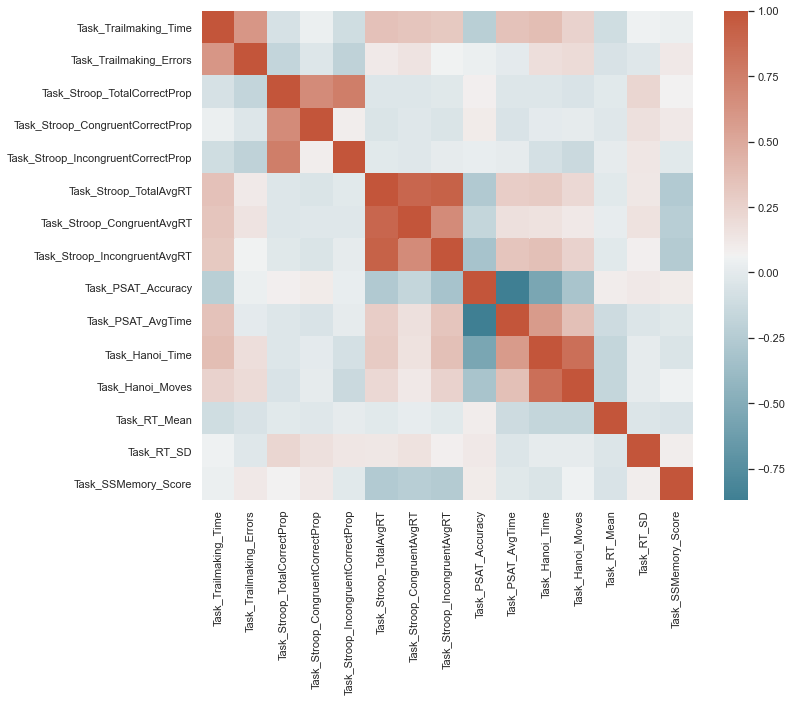

In [66]:
# Compute the correlation matrix
corr = df_tasks.iloc[:,2:].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, n=9, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, cmap=cmap)